In [289]:
%load_ext autoreload
%autoreload 2
import gc
import sys

gc.collect()

paths_to_add = ['/home/jovyan/work', '/home/jupyter/alpha_media_signal']

for p in paths_to_add:
    if p not in sys.path:
        sys.path.append(p)

import pandas as pd

from ams.services.equities.EquityFundaDimension import EquityFundaDimension
%matplotlib inline
from pathlib import Path

from ams.config import constants
from ams.services import twitter_service
from ams.services import ticker_service

from statistics import mean
import numpy as np
from ams.services import file_services
from typing import List

pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [290]:
twitter_folder = 'twitter'

tr_file_path = Path(constants.TWITTER_OUTPUT_RAW_PATH, "tip_ranked", "main", "tip_rank_2020-12-14_22-48-27-354.17.parquet")

learning_prep_dir = Path(constants.DATA_PATH, twitter_folder, "great_reduction", "main")
# learning_prep_dir = Path(constants.DATA_PATH, twitter_folder, "learning_prep_drop", "lpd")

file_paths = file_services.list_files(parent_path=learning_prep_dir, ends_with=".parquet", use_dir_recursion=True)

In [291]:
%%time

all_dfs = []
for f in file_paths:
    df = pd.read_parquet(f)
    all_dfs.append(df)

df_twitter_raw = pd.concat(all_dfs, axis=0)

max_date = df_twitter_raw["date"].max()
print(f"Max date: {max_date}")
print(f"Count: {df_twitter_raw.shape[0]}")

Max date: 2020-12-27
Count: 228582
Wall time: 1.16 s


In [292]:
df_twitter_raw.columns

Index(['created_at', 'user_screen_name', 'favorite_count', 'in_reply_to_screen_name', 'user_verified', 'metadata_result_type', 'user_listed_count', 'user_time_zone', 'user_has_extended_profile', 'in_reply_to_status_id', 'user_statuses_count', 'user_protected', 'user_is_translation_enabled', 'user_location', 'lang', 'user_geo_enabled', 'place_country', 'place_name', 'possibly_sensitive', 'user_friends_count', 'retweet_count', 'user_follow_request_sent', 'user_followers_count', 'f22_ticker', 'f22_has_cashtag', 'f22_ticker_in_text', 'f22_num_other_tickers_in_tweet', 'f22_sentiment_pos', 'f22_sentiment_neu', 'f22_sentiment_neg', 'f22_sentiment_compound', 'f22_id', 'created_at_timestamp', 'date', 'f22_compound_score', 'f22_is_tweet_after_hours'], dtype='object')

Wall time: 508 ms


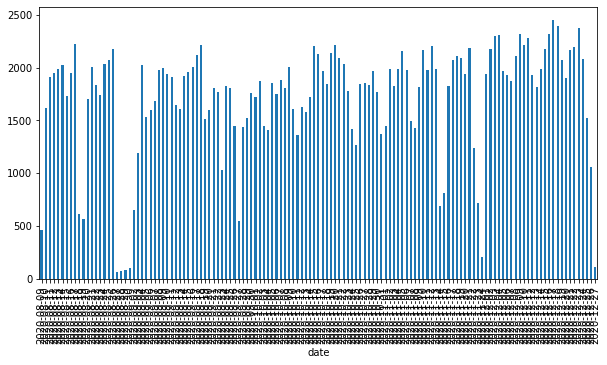

In [293]:
%%time 

def show_distribution(df: pd.DataFrame, group_column_name:str="date"):
    df.sort_values(by=[group_column_name], inplace=True)

    day_groups = df.groupby(df[group_column_name])[group_column_name].count()

    day_groups.plot(kind='bar', figsize=(10,5), legend=None)

show_distribution(df=df_twitter_raw)

In [294]:
%%time

df_booled = twitter_service.convert_to_bool(df=df_twitter_raw)
print(df_booled["date"].max())

2020-12-27
Wall time: 3.67 s


2020-12-27
120569
Wall time: 1min 6s


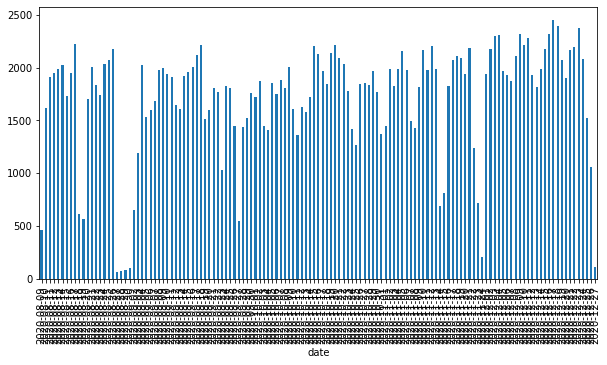

In [295]:
%%time
df_twitter = df_booled

def coerce_convert_to_numeric(df: pd.DataFrame, col: str):
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col] = df[col].fillna(0)
    return df

df_twitter = coerce_convert_to_numeric(df=df_twitter, col="user_followers_count")
df_twitter = coerce_convert_to_numeric(df=df_twitter, col="f22_sentiment_compound")
df_twitter = coerce_convert_to_numeric(df=df_twitter, col="f22_compound_score")

df_stock_data = twitter_service.get_stock_data_for_twitter_companies(df_tweets=df_twitter, num_days_in_future=1)

print(df_twitter["date"].max())
print(df_stock_data.shape[0])

show_distribution(df=df_twitter)

In [296]:
df_rec_quart_drop = twitter_service.get_all_quarterly_data_for_twitter()

columns_fundy = list(df_rec_quart_drop.columns)

print(df_rec_quart_drop['calendardate'].max())

2020-12-31


In [297]:
%%time
from ams.services.equities import equity_fundy_service as efs
df_equity_fundies = efs.get_equity_fundies()

df_eq_fun_quarters = df_equity_fundies[df_equity_fundies["dimension"] == EquityFundaDimension.AsReportedQuarterly.value]

df_result = pd.merge(df_eq_fun_quarters, df_stock_data, on=["ticker"], how='outer', suffixes=[None, "_eq_fun"])


Wall time: 8.46 s


In [298]:
df_drop_init = df_result.dropna(subset=["date"]).drop(columns="lastupdated_eq_fun")

df_drop_future = df_drop_init[df_drop_init["date"] > df_drop_init["calendardate"]]

df_drop_future = df_drop_future.sort_values(by=["ticker", "date", "calendardate"], ascending=False)

df_stock_and_quarter = df_drop_future.drop_duplicates(subset=["ticker", "date"], keep="first")

gc.collect()

20642

In [299]:
df_stock_and_quarter.sort_values(by=["ticker", "date", "calendardate"], ascending=True).head(50)

,ticker,dimension,calendardate,datekey,reportperiod,lastupdated,accoci,assets,assetsavg,assetsc,assetsnc,assetturnover,bvps,capex,cashneq,cashnequsd,cor,consolinc,currentratio,de,debt,debtc,debtnc,debtusd,deferredrev,depamor,deposits,divyield,dps,ebit,ebitda,ebitdamargin,ebitdausd,ebitusd,ebt,eps,epsdil,epsusd,equity,equityavg,equityusd,ev,evebit,evebitda,fcf,fcfps,fxusd,gp,grossmargin,intangibles,intexp,invcap,invcapavg,inventory,investments,investmentsc,investmentsnc,liabilities,liabilitiesc,liabilitiesnc,marketcap,ncf,ncfbus,ncfcommon,ncfdebt,ncfdiv,ncff,ncfi,ncfinv,ncfo,ncfx,netinc,netinccmn,netinccmnusd,netincdis,netincnci,netmargin,opex,opinc,payables,payoutratio,pb,pe,pe1,ppnenet,prefdivis,price,ps,ps1,receivables,retearn,revenue,revenueusd,rnd,roa,roe,roic,ros,sbcomp,sgna,sharefactor,sharesbas,shareswa,shareswadil,sps,tangibles,taxassets,taxexp,taxliabilities,tbvps,workingcapital,date,open,high,low,close,volume,dividends,closeunadj,future_open,future_low,future_high,future_close,future_date,None
2244253,AACQ,ARQ,2020-09-30,2020-10-28,2020-09-30,2020-11-03,0.000000e+00,7.261300e+08,NaN,1.551950e+06,7.245781e+08,NaN,0.249,NaN,1.261683e+06,1.261683e+06,0.000000e+00,-6.218500e+04,99.420,5.075,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,NaN,0.0,0.000,0.0,-6.218500e+04,NaN,NaN,NaN,-6.218500e+04,-6.218500e+04,-0.01,-0.01,-0.01,5.000006e+06,NaN,5.000006e+06,8.699496e+08,NaN,NaN,NaN,NaN,1.0,0.0,NaN,0.000000e+00,0.0,7.248527e+08,NaN,0.000000e+00,7.245781e+08,0.000000e+00,724578087.0,2.537311e+07,1.561000e+04,2.535750e+07,8.712112e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.218500e+04,-6.218500e+04,-6.218500e+04,0.0,0.0,NaN,1.402720e+05,-1.402720e+05,0.000000e+00,0.0,174.242,NaN,NaN,0.000000e+00,0.0,9.620,NaN,NaN,0.000000e+00,-7.125400e+04,0.000000e+00,0.000000e+00,0.0,NaN,NaN,NaN,NaN,NaN,0.000000e+00,1.0,90562500.0,20071954.0,20071954.0,0.000,7.261300e+08,0.000000e+00,0.0,0.0,36.176,1.536340e+06,2020-11-11,9.700,9.750,9.700,9.740,2209.0,0.0,9.740,9.725,9.700,9.770,9.700,2020-11-12,NaN
2244254,AACQ,ARQ,2020-09-30,2020-10-28,2020-09-30,2020-11-03,0.000000e+00,7.261300e+08,NaN,1.551950e+06,7.245781e+08,NaN,0.249,NaN,1.261683e+06,1.261683e+06,0.000000e+00,-6.218500e+04,99.420,5.075,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,NaN,0.0,0.000,0.0,-6.218500e+04,NaN,NaN,NaN,-6.218500e+04,-6.218500e+04,-0.01,-0.01,-0.01,5.000006e+06,NaN,5.000006e+06,8.699496e+08,NaN,NaN,NaN,NaN,1.0,0.0,NaN,0.000000e+00,0.0,7.248527e+08,NaN,0.000000e+00,7.245781e+08,0.000000e+00,724578087.0,2.537311e+07,1.561000e+04,2.535750e+07,8.712112e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.218500e+04,-6.218500e+04,-6.218500e+04,0.0,0.0,NaN,1.402720e+05,-1.402720e+05,0.000000e+00,0.0,174.242,NaN,NaN,0.000000e+00,0.0,9.620,NaN,NaN,0.000000e+00,-7.125400e+04,0.000000e+00,0.000000e+00,0.0,NaN,NaN,NaN,NaN,NaN,0.000000e+00,1.0,90562500.0,20071954.0,20071954.0,0.000,7.261300e+08,0.000000e+00,0.0,0.0,36.176,1.536340e+06,2020-12-08,10.440,10.440,10.200,10.310,2927968.0,0.0,10.310,10.400,10.270,10.500,10.300,2020-12-09,NaN
2244255,AACQ,ARQ,2020-09-30,2020-10-28,2020-09-30,2020-11-03,0.000000e+00,7.261300e+08,NaN,1.551950e+06,7.245781e+08,NaN,0.249,NaN,1.261683e+06,1.261683e+06,0.000000e+00,-6.218500e+04,99.420,5.075,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,NaN,0.0,0.000,0.0,-6.218500e+04,NaN,NaN,NaN,-6.218500e+04,-6.218500e+04,-0.01,-0.01,-0.01,5.000006e+06,NaN,5.000006e+06,8.699496e+08,NaN,NaN,NaN,NaN,1.0,0.0,NaN,0.000000e+00,0.0,7.248527e+08,NaN,0.000000e+00,7.245781e+08,0.000000e+00,724578087.0,2.537311e+07,1.561000e+04,2.535750e+07,8.712112e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.218500e+04,-6.218500e+04,-6.218500e+04,0.0,0.0,NaN,1.402720e+05,-1.402720e+05,0.000000e+00,0.0,174.242,NaN,NaN,0.000000e+00,0.0,9.620,NaN,NaN,0.000000e+00,-7.125400e+04,0.000000e+00,0.000000e+00,0.0,NaN,NaN,NaN,NaN,NaN,0.000000e+00,1.0,90562500.0,20071954.0,20071954.0,0.000,7.261300e+08,0.000000e+00,0.0,0.0,36.176,1.536340e+06,2020-12-09,10.400,

In [300]:
df_nas_tickers_info = ticker_service.get_nasdaq_tickers()

C:\Users\Chris\workspaces\alpha_media_signal\ams\services\ticker_service.py:273: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = df[c].fillna("<unknown>")
C:\Users\Chris\workspaces\alpha_media_signal\ams\services\ticker_service.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = df[c].astype(CategoricalDtype(uniques))


In [301]:
%time

col_ticker = "ticker_drop"

df_stock_quart_info = pd.merge(df_stock_and_quarter, df_nas_tickers_info, how='inner', left_on=["ticker"], right_on=[col_ticker])
df_sqi = df_stock_quart_info.drop(columns=[col_ticker])

print(df_sqi.shape)
print(df_sqi["date"].max())
print(df_sqi["date"].min())

Wall time: 0 ns
(217758, 588)
2020-12-23
2020-08-10


In [302]:
%%time

df_stock_renamed = df_sqi.rename(columns={"ticker": "f22_ticker"})

if 'None' in df_stock_renamed.columns:
    df_stock_renamed = df_stock_renamed.drop(columns=['None'])

print(f'Twitter: {df_twitter.shape[0]}')

df_merged = pd.merge(df_twitter, df_stock_renamed, how='inner', left_on=["f22_ticker","date"], right_on=["f22_ticker","date"])

print(f'Num merged: {df_merged.shape[0]}')
print(df_merged["date"].min())
print(df_merged["date"].max())

Twitter: 228582
Num merged: 217758
2020-08-10
2020-12-23
Wall time: 2.87 s


In [303]:
# show_distribution(df=df_result, group_column_name="calendardate")
from ams.utils import date_utils

df_days = df_merged

def num_days_from(from_date: str, to_date: str):
    from_dt = date_utils.parse_std_datestring(from_date)
    to_dt = date_utils.parse_std_datestring(to_date)
    
    return (to_dt - from_dt).days

df_days = df_days.dropna(axis="rows", subset=["datekey", "future_date"])

df_days["days_since"] = df_days.apply(lambda x: num_days_from(x["datekey"], x["future_date"]), axis=1)
df_days[["days_since", "calendardate", "datekey", "reportperiod"]].head(10)

,days_since,calendardate,datekey,reportperiod
0,1,2020-06-30,2020-08-10,2020-06-30
1,1,2020-06-30,2020-08-10,2020-06-30
2,1,2020-06-30,2020-08-10,2020-06-30
3,1,2020-06-30,2020-08-10,2020-06-30
4,1,2020-06-30,2020-08-10,2020-06-30
5,1,2020-06-30,2020-08-10,2020-06-30
6,-24,2020-06-30,2020-09-04,2020-07-31
7,-24,2020-06-30,2020-09-04,2020-07-31
8,4,2020-06-30,2020-08-07,2020-06-30
9,4,2020-06-30,2020-08-07,2020-06-30


In [304]:
%%time

df_days_of = df_days

def day_of_week(date_str):
    return pd.Timestamp(date_str).dayofweek

df_days_of["fd_day_of_week"] = df_days_of.apply(lambda x: day_of_week(x["future_date"]), axis=1)

def day_of_year(date_str):
    return pd.Timestamp(date_str).dayofyear

df_days_of["fd_day_of_year"] = df_days_of.apply(lambda x: day_of_year(x["future_date"]), axis=1)

def day_of_month(date_str):
    return int(date_str.split("-")[2])

df_days_of["fd_day_of_month"] = df_days_of.apply(lambda x: day_of_month(x["future_date"]), axis=1)

Wall time: 15.2 s


In [305]:
df_roi_nasdaq = pd.read_parquet(str(constants.DAILY_ROI_NASDAQ_PATH))
df_roi_nasdaq = df_roi_nasdaq.rename(columns={"roi": "nasdaq_day_roi"})

df_roi_win = pd.merge(df_roi_nasdaq, df_days_of, on=["date"], how="right")

In [306]:
df_roi_win.head()

,date,nasdaq_day_roi,created_at,user_screen_name,favorite_count,in_reply_to_screen_name,user_verified,metadata_result_type,user_listed_count,user_time_zone,user_has_extended_profile,in_reply_to_status_id,user_statuses_count,user_protected,user_is_translation_enabled,user_location,lang,user_geo_enabled,place_country,place_name,possibly_sensitive,user_friends_count,retweet_count,user_follow_request_sent,user_followers_count,f22_ticker,f22_has_cashtag,f22_ticker_in_text,f22_num_other_tickers_in_tweet,f22_sentiment_pos,f22_sentiment_neu,f22_sentiment_neg,f22_sentiment_compound,f22_id,created_at_timestamp,f22_compound_score,f22_is_tweet_after_hours,dimension,calendardate,datekey,reportperiod,lastupdated,accoci,assets,assetsavg,assetsc,assetsnc,assetturnover,bvps,capex,cashneq,cashnequsd,cor,consolinc,currentratio,de,debt,debtc,debtnc,debtusd,deferredrev,depamor,deposits,divyield,dps,ebit,ebitda,ebitdamargin,ebitdausd,ebitusd,ebt,eps,epsdil,epsusd,equity,equityavg,equityusd,ev,evebit,evebitda,fcf,fcfps,fxusd,gp,grossmargin,intangibles,intexp,invcap,invcapavg,inventory,investments,investmentsc,investmentsnc,liabilities,liabilitiesc,liabilitiesnc,marketcap,ncf,ncfbus,ncfcommon,ncfdebt,ncfdiv,ncff,ncfi,ncfinv,ncfo,ncfx,netinc,netinccmn,netinccmnusd,netincdis,netincnci,netmargin,opex,opinc,payables,payoutratio,pb,pe,pe1,ppnenet,prefdivis,price,ps,ps1,receivables,retearn,revenue,revenueusd,rnd,roa,roe,roic,ros,sbcomp,sgna,sharefactor,sharesbas,shareswa,shareswadil,sps,tangibles,taxassets,taxexp,taxliabilities,tbvps,workingcapital,open,high,low,close,volume,dividends,closeunadj,future_open,future_low,future_high,future_close,future_date,table_SEP,table_SF1,table_SF3B,table_<unknown>,table_SFP,category_Domestic Preferred Stock,category_ADR Preferred Stock,category_ETF,category_ETN,category_Canadian Preferred Stock,category_Domestic Stock Warrant,category_Canadian Common Stock,category_ADR Common Stock Primary Class,category_Canadian Common Stock Primary Class,category_ETD,category_CEF,category_ADR Common Stock,category_IDX,category_Domestic Common Stock Primary Class,category_<unknown>,category_Canadian Stock Warrant,category_ADR Stock Warrant,category_Domestic Common Stock Secondary Class,category_Domestic Common Stock,category_ADR Common Stock Secondary Class,sicsector_Agriculture Forestry And Fishing,sicsector_Transportation Communications Electric Gas And Sanitary Service,sicsector_Finance Insurance And Real Estate,sicsector_<unknown>,sicsector_Public Administration,sicsector_Services,sicsector_Nonclassifiable,sicsector_Construction,sicsector_Wholesale Trade,sicsector_Retail Trade,sicsector_Manufacturing,sicsector_Mining,famaindustry_Textiles,famaindustry_Healthcare,famaindustry_Restaraunts Hotels Motels,famaindustry_Candy & Soda,famaindustry_Pharmaceutical Products,famaindustry_Medical Equipment,famaindustry_Consumer Goods,famaindustry_Machinery,famaindustry_Shipping Containers,famaindustry_Petroleum and Natural Gas,famaindustry_Measuring and Control Equipment,famaindustry_Apparel,famaindustry_Coal,famaindustry_Construction Materials,famaindustry_Electronic Equipment,famaindustry_Tobacco Products,famaindustry_Printing and Publishing,famaindustry_Personal Services,famaindustry_Chemicals,famaindustry_Insurance,famaindustry_Retail,famaindustry_Electrical Equipment,famaindustry_Automobiles and Trucks,famaindustry_Wholesale,famaindustry_Almost Nothing,famaindustry_Banking,famaindustry_Food Products,famaindustry_Transportation,famaindustry_<unknown>,famaindustry_Trading,famaindustry_Construction,famaindustry_Business Supplies,famaindustry_Steel Works Etc,famaindustry_Defense,famaindustry_Utilities,famaindustry_Recreation,famaindustry_Rubber and Plastic Products,famaindustry_Non-Metallic and Industrial Metal Mining,famaindustry_Shipbuilding Railroad Equipment,famaindustry_Real Estate,famaindustry_Communication,famaindustry_Agriculture,famaindustry_Beer & Liquor,famaindustry_Precious Metals,famaindustry_Entertainment,famaindustry_Fabricated P

In [307]:
%%time
df_dd = df_roi_win.drop_duplicates(subset=["f22_ticker", "date"])

df_thin_rabbit = twitter_service.add_buy_sell(df=df_dd)

df_thin_rabbit[["f22_ticker", "date", "future_date", "nasdaq_day_roi", "stock_val_change", "stock_val_change_ex"]][df_thin_rabbit["f22_ticker"] == "ABUS"].head(125)

C:\Users\Chris\workspaces\alpha_media_signal\ams\services\twitter_service.py:393: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stock_val_change'] = ((df['future_close'] - df['close']) / df['close']) - df["nasdaq_day_roi"]
C:\Users\Chris\workspaces\alpha_media_signal\ams\services\twitter_service.py:395: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['buy_sell'] = df['stock_val_change'].apply(lambda x: 1 if x >= roi_threshold_pct else -1)
C:\Users\Chris\workspaces\alpha_media_signal\ams\services\twitte

Wall time: 737 ms


,f22_ticker,date,future_date,nasdaq_day_roi,stock_val_change,stock_val_change_ex
3194,ABUS,2020-08-11,2020-08-12,0.001806,0.033078,0.389099
5756,ABUS,2020-08-12,2020-08-13,0.001494,-0.038011,-0.314701
10812,ABUS,2020-08-13,2020-08-14,-0.001569,0.013231,0.374755
12898,ABUS,2020-08-14,2020-08-17,0.005286,-0.002404,-0.339345
16838,ABUS,2020-08-17,2020-08-18,-0.007212,-0.001409,-0.340047
17524,ABUS,2020-08-18,2020-08-19,-0.000283,0.000283,0.365547
17858,ABUS,2020-08-19,2020-08-20,-0.004219,-0.027665,-0.321769
20934,ABUS,2020-08-20,2020-08-21,-0.010672,-0.037232,-0.315230
21654,ABUS,2020-08-21,2020-08-24,-0.001332,-0.052127,-0.305179
24194,ABUS,2020-08-24,2020-08-25,0.008282,-0.011604,-0.332892


In [308]:
df_thin_rabbit["original_close_price"] = df_thin_rabbit["close"]
df_thin_rabbit["date"].max()
print(f'Num df_thin_rabbit: {df_thin_rabbit.shape[0]}')

Num df_thin_rabbit: 108912


c:\programdata\miniconda3\envs\alpha_media_signal\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [309]:
def save_twitter_stock_join(df: pd.DataFrame):
    sorted(list(df.columns))

    file_path_str = str(Path(constants.OVERFLOW_DATA_PATH, "twitter", "inference_model_drop", "twitter_id_with_label.parquet"))

    df.to_parquet(file_path_str)
    
# save_twitter_stock_join(df=df_thin_rabbit)

In [310]:
%%time
cols_fundy_numeric = list(set(columns_fundy) - {"ticker", 'calendardate', 'datekey', 'reportperiod'})

df_no_z = twitter_service.fill_null_numeric(df=df_thin_rabbit, cols_fundy_numeric=cols_fundy_numeric)

Wall time: 463 ms


C:\Users\Chris\workspaces\alpha_media_signal\ams\services\twitter_service.py:420: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[k] = df[k].fillna(v)


In [311]:
%%time
from ams.utils import ticker_utils

df_sma = ticker_utils.add_sma_history(df=df_no_z, target_column="close", windows=[15, 20, 50, 100, 200])

Wall time: 31.1 s


In [325]:
%%time
df_since_sma = ticker_utils.add_days_since_under_sma_many_tickers(df=df_sma, col_sma="close_SMA_200", close_col="close")
df_since_sma = ticker_utils.add_days_since_under_sma_many_tickers(df=df_since_sma, col_sma="close_SMA_15", close_col="close")
df_since_sma = ticker_utils.add_days_since_under_sma_many_tickers(df=df_since_sma, col_sma="close_SMA_20", close_col="close")
df_since_sma = ticker_utils.add_days_since_under_sma_many_tickers(df=df_since_sma, col_sma="close_SMA_50", close_col="close")
df_since_sma = ticker_utils.add_days_since_under_sma_many_tickers(df=df_since_sma, col_sma="close_SMA_100", close_col="close")

Wall time: 1min 2s


In [326]:
%%time

# FIXME: Testing only.
# df_pay = df_since_sma[df_since_sma["f22_is_tweet_after_hours"] == False].copy()
df_since_sma["purchase_date"] = df_since_sma["date"]

Wall time: 1e+03 µs


In [327]:
%%time

df_days_until = ticker_service.add_days_until_sale(df=df_since_sma)

Wall time: 548 ms


In [328]:
class SplitData():
    X_train = None
    y_train = None
    X_test = None
    y_test = None
    df_test_raw = None
    df_test_std = None
    train_cols = None
    has_enough_data = None
    
    def __init__(self, 
                 X_train: np.array,
                 y_train: np.array,
                 X_test: np.array,
                 y_test: np.array,
                 df_test_raw: pd.DataFrame,
                 df_test_std: pd.DataFrame,
                 df_val_raw: pd.DataFrame,
                 df_val_std: pd.DataFrame,
                 train_cols: List[str],
                 has_enough_data: bool
                ):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.df_test_raw = df_test_raw
        self.df_test_std = df_test_std
        self.df_val_raw = df_val_raw
        self.df_val_std = df_val_std
        self.train_cols = train_cols
        self.has_enough_data = has_enough_data

In [329]:
def has_f22_column(df: pd.DataFrame):
    cols = [c for c in df.columns if c.startswith("f22")]
    print(cols)

def split_off_data_new(df: pd.DataFrame, narrow_cols: List[str], tickers: List[str] = None, use_recent_for_holdout = True) -> SplitData :
    df_samp, df_val_raw = twitter_service.ho_split_by_days(df, 
                                                            small_data_days_to_pull=None, 
                                                            small_data_frac=.025, 
                                                            use_only_recent_for_holdout=use_recent_for_holdout)
        
    X_train = None
    y_train = None
    X_test = None
    y_test = None
    df_test_raw = None
    df_test_std = None
    df_val_std = None
    train_cols = None
    
    
    has_enough_data = df_samp is not None and df_val_raw is not None and df_val_raw.shape[0] > 500
    if has_enough_data:

        df_shuff = df_samp.sample(frac=1.0)

        df_train_raw, df_test_raw = twitter_service.ho_split_by_days(df_shuff, small_data_days_to_pull=None, small_data_frac=.2, use_only_recent_for_holdout=use_recent_for_holdout) #        

        has_enough_data = df_train_raw is not None and df_test_raw is not None and df_test_raw.shape[0] > 500
        if has_enough_data:
            print(f"Original: {df.shape[0]}; train_set: {df_train_raw.shape[0]}; test_set: {df_test_raw.shape[0]}")

            df_train_std, df_test_std, df_val_std = ticker_service.std_dataframe(df_train=df_train_raw, df_test=df_test_raw, df_val=df_val_raw)

            X_train, y_train, X_test, y_test, train_cols = twitter_service.split_train_test(train_set=df_train_std, test_set=df_test_std, narrow_cols=narrow_cols, label_col="stock_val_change")

        return SplitData(X_train=X_train,
                       y_train=y_train,
                       X_test=X_test,
                       y_test=y_test,
                       df_test_raw=df_test_raw,
                       df_test_std=df_test_std,
                       df_val_raw=df_val_raw,
                       df_val_std=df_val_std,
                       train_cols=train_cols,
                       has_enough_data=has_enough_data)
    if not has_enough_data:
        print("Not enough data.")

In [330]:
%%time

min_volume = None
min_price = None
max_price = None

# min_volume = 100000
# min_price = 5.00
# max_price = 3.

# min_volume = None
# min_price = None
# max_price = 3.

df = twitter_service.refine_pool(df=df_days_until, min_volume=min_volume, min_price=min_price, max_price=max_price)
df = twitter_service.omit_columns(df=df)
df_tweet_counted = twitter_service.add_tweet_count(df=df).drop(columns=["calendardate", "reportperiod", "dimension", "datekey"])

df_tweet_counted[["f22_ticker", "date", "future_date", "nasdaq_day_roi", "stock_val_change", "stock_val_change_ex"]][df_tweet_counted["f22_ticker"] == "ABUS"].head(125)

Wall time: 2.9 s


,f22_ticker,date,future_date,nasdaq_day_roi,stock_val_change,stock_val_change_ex
85220,ABUS,2020-12-01,2020-12-02,0.002580,-0.012605,-0.332193
87603,ABUS,2020-12-02,2020-12-03,0.008510,-0.011042,-0.333284
91598,ABUS,2020-12-07,2020-12-08,0.011948,-0.052454,-0.304960
93276,ABUS,2020-12-09,2020-12-10,0.014326,0.061920,0.410440
95363,ABUS,2020-12-10,2020-12-11,-0.004053,0.069448,0.416107
97409,ABUS,2020-12-11,2020-12-14,0.003129,0.244953,0.559571
99938,ABUS,2020-12-15,2020-12-16,0.000311,-0.112988,-0.265737


In [331]:
from matplotlib.legend_handler import HandlerLine2D
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import numpy as np

def randy_forest(X_train: np.array, y_train: np.array, X_test: np.array, y_test: np.array):
    n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
    train_results = []
    test_results = []

    for estimator in n_estimators:
        rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
        rf.fit(X_train, y_train)
        train_pred = rf.predict(X_train)
        from sklearn.metrics import roc_curve
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        from sklearn.metrics import auc
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)
        y_pred = rf.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)

    line1, = plt.plot(n_estimators, train_results, 'b', label="Train AUC")
    line2, = plt.plot(n_estimators, test_results, 'r', label="Test AUC")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('AUC score')
    plt.xlabel('n_estimators')
    plt.show()

In [332]:
def rnd_forest_clf(X_train: np.array, y_train: np.array, X_test: np.array, y_test: np.array):
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import accuracy_score

    rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
     max_depth=None, max_features='auto', max_leaf_nodes=None,
     min_impurity_split=1e-07, min_samples_leaf=1,
     min_samples_split=2, min_weight_fraction_leaf=0.0,
     n_estimators=1, n_jobs=1, oob_score=False, random_state=None,
     verbose=0, warm_start=False)
    rf.fit(X=X_train, y=y_train)

    y_test_pred = rf.predict(X_test)

    print(accuracy_score(y_test, y_test_pred))

    return rf

In [333]:
def find_columns_with_value(df: pd.DataFrame, value_to_find: any):
    col_matched = []
    for c in df.columns:
        df = df[df[c] == value_to_find]
        if df.shape[0] > 0:
            col_matched.append(c)

    return col_matched

In [334]:
cols = list(df_tweet_counted.columns)

# cols = [c for c in cols if not c.startswith("location_")]
# cols = [c for c in cols if not c.startswith("currency_")]
# cols = [c for c in cols if not c.startswith("industry_")]
# cols = [c for c in cols if not c.startswith("famaindustry_")]
# cols = [c for c in cols if not c.startswith("category_")]
# cols = [c for c in cols if not c.startswith("sector_")]
# cols = [c for c in cols if not c.startswith("scalerevenue_")]
# cols = [c for c in cols if not c.startswith("table_")]
# cols = [c for c in cols if not c.startswith("sicsector_")]
# cols = [c for c in cols if not c.startswith("scalemarketcap_")]

# cols = list(set(cols) - {'sharesbas', 'sps', 'ps', 'receivables', 'debtnc', 'invcap', 'sbcomp', 'workingcapital',
#                         'taxliabilities', 'ebt', 'retearn', 'accoci', 'invcapavg', 'liabilitiesnc', 'pb', 'taxassets',
#                          'revenueusd', 'price', 'netincdis', 'sharefactor', 'netmargin', 'ncfcommon', 'investmentsc', 'opinc',
#                          'inventory', 'eps', 'de', 'sgna', 'siccode', 'fxusd', 'revenue', 'opex', 'cashnequsd', 'tbvps', 'shareswa', 
#                          'ros', 'evebitda', 'ncfdebt', 'consolinc', 'ncfinv', 'deposits', 'marketcap', 'ev', 'roe', 'payoutratio',
#                          'investmentsnc', 'equity', 'roa', 'divyield', 'investmentsnc', 'equity', 'roa', 'divyield', 'ps1', 
#                          'shareswadil', 'liabilitiesc', 'gp', 'tangibles', 'epsusd', 'assetsnc', 'ppnenet', 'epsdil', 'ncfdiv',
#                           'ncfi', 'payables', 'fcfps', 'investments', 'cashneq', 'roic', 'currentratio', 'ebit', 'ebitda', 
#                          'volume', 'ncfo', 'netinc', 'netinccmn', 'debt', 'pe', 'debtc', 'rnd', 'evebit', 'ebitusd', 'netincnci', 
#                          'assetsc', 'assetsavg', 'assetturnover', 'taxexp', 'ebitdausd', 'liabilities', 'capex', 'prefdivis',
#                          'netinccmnusd', 'depamor', 'famasector', 'dps', 'assets', 'fcf', 'ebitdamargin', 'equityusd', 'ncfx', 
#                          'ncfbus', 'equityavg', 'dividends', 'cor', 'grossmargin', 'ncff', 'intangibles', 'debtusd', 'bvps', 'pe1',
#                          'intexp', 'ncf'
#                         })
# print(f"Total cols: {len(cols)}")

col_drop = set(df_tweet_counted.columns) - set(cols)

df_winnowed = df_tweet_counted.drop(columns=col_drop).reset_index(drop=True)

max_val = df_winnowed["stock_val_change_ex"].max()
min_val = df_winnowed["stock_val_change_ex"].min()

In [335]:
df_tip_ranks = pd.read_parquet(str(tr_file_path))
df_tip_ranks = df_tip_ranks.rename(columns={"ticker": "f22_ticker"})

df_ranked = pd.merge(df_winnowed, df_tip_ranks, on=["date", "f22_ticker"], how="left")

def rank_roied(row):
    close = row["close"]
    target_price = row["target_price"]
    rank_roi = None
    
    if target_price is None:
        target_price = close + .01
        
    target_price = row["target_price"]
    rank_roi = (target_price - close)/close
        
    return rank_roi

df_ranked["rank_roi"] = df_ranked.apply(rank_roied, axis=1)

rating_mean = df_tip_ranks["rating"].mean()
rank_mean = df_tip_ranks["rank"].mean()
rating_age_days_mean = df_tip_ranks["rating_age_days"].mean()

df_ranked["rating"] = df_ranked["rating"].fillna(0)
df_ranked["rank"] = df_ranked["rank"].fillna(rank_mean)
df_ranked["rating_age_days"] = df_ranked["rating_age_days"].fillna(1000)

df_tip_ranks.head()

,rating,rank,rating_age_days,target_price,f22_ticker,date
0,0.80,3.28,45.00,48.0920,ALLO,2020-08-09
1,0.25,4.65,58.75,238.0000,COUP,2020-08-09
2,1.00,4.60,19.00,47.0000,GO,2020-08-09
3,0.50,4.40,21.50,94.5000,DDOG,2020-08-09
4,1.00,4.40,48.00,15.9375,ARCC,2020-08-09


In [336]:
list(df_ranked.columns)

['industry_Beverages - Non-Alcoholic',
 'category_CEF',
 'location_Alberta; Canada',
 'f22_sentiment_neg',
 'deferredrev',
 'ncf',
 'scalerevenue_6 - Mega',
 'location_Michigan; U.S.A',
 'buy_sell',
 'location_British Columbia; Canada',
 'location_Virginia; U.S.A',
 'currency_KRW',
 'user_followers_count',
 'currency_HKD',
 'location_Ohio; U.S.A',
 'dividends',
 'table_SF1',
 'nasdaq_day_roi',
 'industry_Rental & Leasing Services',
 'location_Oregon; U.S.A',
 'close',
 'famaindustry_Candy & Soda',
 'ebitda',
 'famaindustry_Defense',
 'industry_Consumer Electronics',
 'industry_<unknown>',
 'location_Taiwan',
 'industry_Silver',
 'location_Denmark',
 'scalerevenue_<unknown>',
 'user_is_translation_enabled',
 'category_ADR Common Stock Primary Class',
 'currency_BRL',
 'location_Puerto Rico',
 'industry_Diversified Industrials',
 'location_Japan',
 'location_Ontario; Canada',
 'close_SMA_50',
 'location_Maine; U.S.A',
 'location_Finland',
 'location_Oklahoma; U.S.A',
 'industry_Specialty

In [337]:
from pandas import CategoricalDtype
def make_one_hotted(df: pd.DataFrame, df_all_tickers: pd.DataFrame, cols: List[str]):
    df_one_hots = []
    for c in cols:
        df_all_tickers[c] = df_all_tickers[c].fillna("<unknown>")
        uniques = df_all_tickers[c].unique().tolist()
        uniques.append("<unknown>")
        uniques = list(set(uniques))

        df[c] = df[c].fillna("<unknown>")
        df[c] = df[c].astype(CategoricalDtype(uniques))
        df_new_cols = pd.get_dummies(df[c], prefix=c)
        df_one_hots.append(df_new_cols)
        
    return pd.concat(df_one_hots, axis=1)

df_ticker_hotted = make_one_hotted(df=df_ranked, df_all_tickers=df_ranked, cols=["f22_ticker"])

df_ticker_hotted = pd.concat([df_ranked, df_ticker_hotted], axis=1)

narrow_cols = list(df_ticker_hotted.columns)
narrow_cols

['industry_Beverages - Non-Alcoholic',
 'category_CEF',
 'location_Alberta; Canada',
 'f22_sentiment_neg',
 'deferredrev',
 'ncf',
 'scalerevenue_6 - Mega',
 'location_Michigan; U.S.A',
 'buy_sell',
 'location_British Columbia; Canada',
 'location_Virginia; U.S.A',
 'currency_KRW',
 'user_followers_count',
 'currency_HKD',
 'location_Ohio; U.S.A',
 'dividends',
 'table_SF1',
 'nasdaq_day_roi',
 'industry_Rental & Leasing Services',
 'location_Oregon; U.S.A',
 'close',
 'famaindustry_Candy & Soda',
 'ebitda',
 'famaindustry_Defense',
 'industry_Consumer Electronics',
 'industry_<unknown>',
 'location_Taiwan',
 'industry_Silver',
 'location_Denmark',
 'scalerevenue_<unknown>',
 'user_is_translation_enabled',
 'category_ADR Common Stock Primary Class',
 'currency_BRL',
 'location_Puerto Rico',
 'industry_Diversified Industrials',
 'location_Japan',
 'location_Ontario; Canada',
 'close_SMA_50',
 'location_Maine; U.S.A',
 'location_Finland',
 'location_Oklahoma; U.S.A',
 'industry_Specialty

In [338]:
%%time
import random
from ams.notebooks.twitter import twitter_ml_utils
from sklearn.metrics import plot_confusion_matrix

# raise Exception("Add time data Monday, Tuesday, first of month, etc.")
# Add technical details? 20MA, etc?

def find_ml_pred_perf(df: pd.DataFrame):
    zero_in = True
    if zero_in:
        target_roi_frac = 0.06
    else:
        target_roi_frac = .001

    print(f"Count: {df.shape[0]}")

    use_rnd_forest = True
    use_regression = False

    all_avgs = []

    tickers = df["f22_ticker"].unique().tolist()
    random.shuffle(tickers)

    sac_roi_list = []

    count = 0
    while True:
        sd = twitter_ml_utils.split_off_data(df=df, narrow_cols=narrow_cols, use_recent_for_holdout=True)
        if sd and sd.has_enough_data:
            X_train = sd.X_train
            y_train = sd.y_train
            X_test = sd.X_test
            y_test = sd.y_test
            df_test_raw = sd.df_test_raw
            df_test_std = sd.df_test_std
            df_val_raw = sd.df_val_raw
            df_val_std = sd.df_val_std
            train_cols = sd.train_cols
            has_enough_data = sd.has_enough_data
            
            if df_test_raw.shape[0] == 0:
                raise Exception("No holdout data.")

            if use_rnd_forest:

                if use_regression:
                    model = twitter_service.dec_tree_regressor(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, max_depth=16)
                else:
                    # randy_forest(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
                    # model = rnd_forest_clf(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
                    print(f"Size of X_train: {X_train.shape[0]}")
                    
                    model = twitter_service.dec_tree(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, max_depth=16) 
    
                acc_model = model
            else:
                acc_model = twitter_service.train_mlp(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
                
            df_splitted = twitter_service.join_with_stock_splits(df=df_val_raw)
            
            if use_regression:
                g_tickers, group_preds = twitter_ml_utils.group_and_mean_preds_regress(df_val_std, acc_model, train_cols)
            else:
                g_tickers, group_preds = twitter_ml_utils.group_and_mean_preds_buy_sell(df_val_std, acc_model, train_cols)

            roi_list, sac_roi, trade_history = twitter_ml_utils.get_roi_matrix(df=df_splitted, group_preds=group_preds, target_roi_frac=target_roi_frac, zero_in=zero_in)
            
            overwrite_existing = True if count == 0 else False
            twitter_ml_utils.persist_trade_history(twitter_trades=trade_history, overwrite_existing=True)
            
            if len(roi_list) > 0:
                max_avg = max(roi_list)
                all_avgs.append(max_avg)

            if sac_roi is not None:
                sac_roi_list.append(sac_roi)
            
            if len(all_avgs) > 0 and len(sac_roi_list) > 0:
                print(f"Cumulative Metrics: Avg Best Sell@High ROI rate: {mean(all_avgs)} | Avg Sell@Close ROI: {mean(sac_roi_list)} ")

        df, has_remaining_days = twitter_service.remove_last_days(df=df, num_days=1)

        if not has_remaining_days:
            print("No more remaining days to test.")
            break
            
        count += 1
        
    return sac_roi_list
            
# ml_pred_fraction = 1.0
# df_4_model = df_skinny.sample(frac=ml_pred_fraction)
# sac_roi_list = find_ml_pred_perf(df=df_4_model)

Wall time: 0 ns


In [339]:
def show_confusion_matrix(clf, X_test, y_test):
    disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=["buy", "sell"],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
    disp.ax_.set_title("Confusion Matrix (Buy/Sell))")

    plt.show()

In [340]:
from torch.utils.data import Dataset
import random
import torch
import torch.nn as nn
import torch.optim as optim
num_iterations = 1
from torch.utils.data import DataLoader

class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


## test data    
class testData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [341]:
import copy
BATCH_SIZE = 1
LEARNING_RATE = .0001
from ams.utils.Stopwatch import Stopwatch

def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

def train(model, data_loader, epoch_ndx, criterion: object, optimizer: object, device: object):
    model.train()
    train_loss = 0
    epoch_loss = 0
    epoch_acc = 0
    start = Stopwatch(start_now=True)
    for batch_idx, (X_batch, y_batch) in enumerate(data_loader):
        
        optimizer.zero_grad()
        
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
     
    num_items = len(data_loader)
    avg_loss = epoch_loss/num_items
    avg_acc = epoch_acc/num_items
    print(f'Epoch {epoch_ndx+0:03}: | Loss: {avg_loss:.5f} | Acc: {avg_acc:.3f}')
    
    start.end(msg="Epoch time")
    
    return avg_loss, avg_acc

def test(model, data_loader, criterion: object, device: object):
    model.eval()
    test_loss = 0
    correct = 0
    total_loss = 0
    total_acc = 0
    with torch.no_grad():
        count_loops = 0
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            y_pred = model(X_batch)
        
            loss = criterion(y_pred, y_batch.unsqueeze(1))
            acc = binary_acc(y_pred, y_batch.unsqueeze(1))

            total_loss += loss.item()
            total_acc += acc.item()
            count_loops += 1
        
    num_items = len(data_loader.dataset)
    avg_loss = total_loss / num_items
    avg_acc = total_acc / count_loops
    
    print(f'\nTest loss: {avg_loss:.4f} | Acc: {avg_acc:.2f}% | Count_loops: {count_loops})\n')
    
    return avg_loss, avg_acc

def train_model(model: object, train_loader: object, test_loader: object, criterion: object, optimizer: object, device: object):

    model.train()
    EPOCHS = 200

    last_t_loss = 9999999999
    best_test_loss = 9999999999
    best_test_acc = 0
    countdown = 0
    max_wait_countdown = 3
    for e in range(1, EPOCHS + 1):
        loss, acc = train(model, train_loader, e, criterion=criterion, optimizer=optimizer, device=device)
        t_loss, t_acc = test(model, test_loader, criterion=criterion, device=device)

        # Overfitting guard
#         if t_loss < best_test_loss:
        if t_acc > best_test_acc:
            best_test_loss = t_loss
            best_test_acc = t_acc
            
            best_model = copy.deepcopy(model)
            countdown = 0
        else:
            countdown += 1

        if countdown >= max_wait_countdown:
            break

    print(f"Best loss: {loss} | best acc: {acc}% | best test loss: {best_test_loss} | best test acc: {best_test_acc}%")
    
    return best_model

In [342]:

class BinaryClassification(nn.Module):
#     def __init__(self, num_input_features: int):
#         super(BinaryClassification, self).__init__()
#         #Our network consists of 3 layers. 1 input, 1 hidden and 1 output layer
#         #This applies Linear transformation to input data. 
#         self.fc1 = nn.Linear(num_input_features, num_input_features - 10)
#         #This applies linear transformation to produce output data
#         self.fc2 = nn.Linear(num_input_features - 10, num_input_features)
#         self.layer_out = nn.Linear(num_input_features, 1)
#         self.relu = nn.ReLU()
        
#     #This must be implemented
#     def forward(self, inputs):
#         #Output of the first layer
#         x = self.relu(self.fc1(inputs))
#         x = self.relu(self.fc2(x))
#         #This produces output
#         x = self.layer_out(x)
        
#         return x
        
    # .003 daily roi
    def __init__(self, num_input_features: int):
        super(BinaryClassification, self).__init__()
        self.layer_1 = nn.Linear(num_input_features, num_input_features - 10) 
        self.layer_2 = nn.Linear(num_input_features - 10, num_input_features)
        self.layer_out = nn.Linear(num_input_features, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(num_input_features - 10,)
        self.batchnorm2 = nn.BatchNorm1d(num_input_features)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x


def initialize_gpu():
    torch.cuda.empty_cache()
    if torch.cuda.is_available():
        torch.cuda.set_device(0)
        device = torch.device('cuda:0')
        print("Using GPU")
    else:
        print("Using CPU")
        device = torch.device('cpu')
    
    return device

def get_initialized_model(num_input_features: int, device: object):
    model = BinaryClassification(num_input_features)
    model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    return model, criterion, optimizer

def calc_nn_roi(
                df_val_raw: pd.DataFrame, 
                df_val_std: pd.DataFrame, 
                model: object, 
                train_cols: List[str],
                target_roi_frac: float,
                zero_in: bool,
                is_model_torch: bool = True,
                is_batch_first_run: bool = False
               ):

    all_avgs = []
    sac_roi_list = []
    if df_val_raw.shape[0] == 0:
        raise Exception("No holdout data.")

    g_tickers, group_preds = twitter_ml_utils.group_and_mean_preds_buy_sell(df_val_std, model, train_cols, is_model_torch=is_model_torch)

    df_splitted = twitter_service.join_with_stock_splits(df=df_val_raw)

    roi_list, sac_roi, trade_history = twitter_ml_utils.get_roi_matrix(df=df_splitted, group_preds=group_preds, target_roi_frac=target_roi_frac, zero_in = zero_in)

    twitter_ml_utils.persist_trade_history(twitter_trades=trade_history, overwrite_existing=is_batch_first_run)
            
    if len(roi_list) > 0:
        max_avg = max(roi_list)
        all_avgs.append(max_avg)

    if sac_roi is not None:
        sac_roi_list.append(sac_roi)

    target_roi_frac += .001

    if len(all_avgs) > 0 and len(sac_roi_list) > 0:
        print(f"Mean s@high: {mean(all_avgs)} | mean sac_roi: {mean(sac_roi_list)}")
    
    return sac_roi_list

In [343]:
# for c in narrow_cols:
#     dtype = str(df_tweet_counted[c].dtype)
#     if dtype not in ['uint8', 'float64', 'int64', 'int32', 'bool']:
#         print(f"{c}: {dtype}")
# df_tweet_counted.shape[0]

# print(narrow_cols)

# print(len(list(df_tweet_counted["user_screen_name"].unique())))

# df_tweet_counted.sort_values(by="date", ascending=False, inplace=True)
# df_tweet_counted["date"].head(10)
# print(narrow_cols)

# TOP_2019 = ["AMZN", "NFLX", "COP", "EC", "ABMD", "VEEV", "SNP", "CTL", "SQ", "SHOP"]
# TOP_2020 = ['PYPL', 'TSLA', 'AMZN', 'CMCSA', 'FB', 'INTC', 'AAPL', 'NVDA', 'MSFT', 'NFLX', 'PEP', 'CSCO', 'ADBE', 'GOOGL', 'WDAY', 'DOCU', 'NBIX', 'AAL', 'TXN', 'TLRY', 'NBL', 'AVGO', 'SIVB', 'WDC', 'MEDI', 'CINF', 'DNA', 'GMST', 'NOVL', 'LKQ', 'CHTR', 'LINE', 'TLSNY', 'SIRI', 'ORLY', 'TMUS', 'ATML', 'ZION', 'GRRF', 'GRPN', 'GRMN', 'PALM', 'SII1', 'ZM', 'GRFS', 'ZNGA', 'MDVN', 'LIFE2', 'GR', 'GILD', 'CHRT', 'CHRW', 'GPRO', 'ATVI', 'MOLX', 'ZS', 'DOX', 'REG', 'REGN', 'IONS', 'DLTR', 'GMCR', 'TIBX', 'BBBY', 'MFNXQ', 'STLD', 'SLM', 'GMAB', 'GH', 'LNT', 'ATHM1', 'ACGL', 'SEDG', 'IPGP', 'ENDP', 'OTEX', 'TIBB', 'SLXP', 'MEL', 'MELI', 'SEBL', 'GENZ', 'BCOR', 'STNE', 'SWKS', 'LOGI', 'ULTA', 'QRTEA', 'CHIR1', 'DIGX', 'RFMD', 'STCN', 'GLPI', 'GLPG', 'ABMD', 'KRFT', 'LLTC', 'DKNG', 'TLAB', 'AYE', 'WBA', 'AZN', 'WB', 'SEIC', 'HK1', 'MNST', 'DISH', 'DISCA', 'CHKP', 'QRVO', 'UB', 'SSNC', 'CMRCQ', 'PCYC', 'TW', 'WWY', 'NTAP', 'WYNN', 'WLTW', 'SRCL', 'MLNM', 'XEL', 'GDS', 'SGEN', 'LBRDA', 'ARMH', 'EBAY', 'LBTYA', 'MCWEQ', 'CG', 'XLNX', 'GEC', 'MLCO', 'HBOC', 'TRB', 'MDB', 'WMG', 'EA', 'CME', 'TCGIA', 'PPD', 'DTV1', 'TTWO', 'TRMB', 'APOL', 'MYL', 'CERN', 'SPWR', 'INKT', 'TRIP', 'DWRI', 'HQCL', 'TVGIA', 'CMVT', 'SHLD', 'NTES', 'EDS', 'DXCM', 'HET', 'TCOMA', 'LCTO', 'TCOM', 'ARBA', 'PDD', 'RATL', 'MKTX', 'RBAK', 'ASO1', 'SRPT', 'YHOO', 'SHPG', 'GTW', 'HNZ', 'NKLA', 'YNDX', 'MDLZ', 'PFG', 'NKTR', 'SIAL', 'Z', 'GT', 'NLOK', 'PAYX', 'ZBRA', 'STOR1', 'UAL', 'INTU', 'WFM', 'ZI', 'ASND1', 'ASML', 'NSOL', 'HBAN', 'XOXO1', 'XP', 'PCAR', 'TWTC', 'WIX', 'GEMP1', 'HOLX', 'HAS', 'RBBN', 'NIHDQ', 'XRAY', 'HAND', 'CGNX', 'XTO', 'GX', 'NIPNY', 'DELL1', 'ACTA', 'FMKT', 'SPLK', 'MAT', 'SBUX', 'EXDS', 'CTAS', 'ALXN', 'SPLS', 'JD', 'CSX', 'AMAT', 'ODP', 'ODFL', 'COMS1', 'AMCC', 'JBHT', 'JAZZ', 'PTON', 'VITR', 'AMD', 'EXPD', 'FLEX', 'EXPE', 'CSGP', 'JAVA', 'EXC', 'ALTR1', 'AMGN', 'EXAS', 'ETSY', 'NTRS', 'CTXS', 'ALGN', 'NDSN', 'ALKS', 'CTSH', 'VMED', 'CTRX', 'OKTA', 'BRCD', 'BRCM', 'SOTR', 'ISRG', 'JKHY', 'ALNY', 'MAR', 'MASI', 'PSFT', 'UVN', 'ETEK1', 'COX', 'PTC', 'FEYE', 'FDRY', 'MCLDQ', 'ANGI', 'SBAC', 'ITWO', 'NXTL', 'NXPI', 'MCDT', 'VEON', 'SANM', 'NWL', 'CPRT', 'CAR', 'CPWR', 'MCIC', 'ANSS', 'MCHP', 'CA', 'NVAX', 'EXTR', 'NVCR', 'FITB', 'FISV', 'VIGN', 'BVSN', 'BVXV', 'CRWD', 'FANG', 'BWNG', 'IYCOY', 'VIAV', 'AMTD', 'COST', 'COUP', 'RYAAY', 'FAST', 'VIAC', 'BYND', 'VIAB', 'FFIV', 'ETFC', 'VOD', 'BGNE', 'FWONA', 'FWLT', 'QDEL', 'UPCOY', 'MERQ', 'BIDU', 'LSI1', 'BIIB', 'BILI', 'QCOM', 'TFCF', 'VRTX', 'EQIX', 'VRTS1', 'STX', 'FTNT', 'BIVV', 'RNWK', 'VSTR1', 'DBX', 'SNDK', 'ULTI', 'KLAC', 'BEAS', 'QLGC', 'SDLI', 'ADCT1', 'QKKAD', 'DDOG', 'ADI', 'IQ', 'VTSS', 'ADP', 'ADSK', 'LRCX', 'DCLK', 'KHC', 'BGEN', 'TEAM', 'LYFT', 'NDAQ', 'BMRN', 'LYO', 'CDW', 'ROST', 'NTNX', 'SNY', 'AKAM', 'BNI', 'ESRX', 'BNTX', 'ON', 'AKZOY', 'RPRX', 'CDNS', 'FOXA', 'FOX1', 'BMET', 'BMC', 'ERIC', 'VRSN', 'VRSK', 'BKNG', 'AFM', 'ERIE', 'ROH', 'TER', 'LULU', 'SUN1', 'SCMR', 'FSLR', 'AGNC', 'CELG', 'ROKU', 'SNPS', 'LVGO', 'TECH', 'ONIS', 'BLUE', 'JUNO', 'NWSA', 'PODD', 'HUNT', 'POOL', 'PLL', 'IEP', 'IDXX', 'IBEM', 'IAC', 'HZNP', 'IMNX', 'MTCH2', 'PMCS', 'IMMU', 'MTCH', 'MRNA', 'INAPQ', 'TROW', 'ILMN', 'MRVL', 'MU', 'MPWR', 'INCY', 'TSCO', 'TSRO', 'HSIC', 'MXIM', 'TSIX1', 'PGN1', 'TTD', 'HTHT', 'ISIL', 'IIXL', 'APAGF', 'SVNX', 'AONEQ', 'EXPO', 'ISHP1', 'MCIP', 'CVBF', 'EXXIQ', 'APCC', 'ESPR', 'MRX', 'ARRY1', 'BRKR', 'ITMR', 'API', 'MDCO', 'ESLT', 'MRVC', 'EXFO', 'ARTG', 'MLHR', 'SNCR', 'EXEL', 'STAY', 'MIPS', 'IDTI', 'ITMN', 'MINI', 'TMTA', 'CY', 'BRKS', 'MLNX', 'ISCA', 'PLXS', 'MSLV', 'IDIX', 'SNDA', 'EXLS', 'BOBJ', 'EXNT1', 'CYCL', 'SNDE', 'ITCD', 'SSTI1', 'SSSW', 'MKSI', 'ISBC', 'FCFS', 'EXPEA', 'MUSE', 'IRWD', 'ASCL', 'MEDP', 'SNDV', 'FCEL', 'SODA', 'ARUN', 'BUCY', 'ESPRY', 'MDGL', 'ITRI', 'BOKF', 'STAA', 'ESGR', 'CYBR', 'ARVN', 'PSEC', 'SSYS', 'ISEE', 'ARWR', 'BUFF', 'BRL', 'IKN', 'AQNT', 'IIXC', 'STRA', 'IIVI', 'APPB', 'EVEP', 'ARCE', 'MDSO', 'EVBG', 'IGTE', 'ARCC1', 'CWTRQ', 'PRXL', 'CWST', 'PLUG', 'MDRX', 'ARGX', 'ARIA', 'ETYS', 'BPOP', 'SNRA', 'STRZA', 'EWBC', 'CWCIQ', 'MSTR', 'BPY', 'BPYU', 'ARRS', 'TMWD', 'PSMT', 'CZR2', 'EVOQ', 'EVOP', 'CZR1', 'CZR', 'TMCS', 'APPX', 'DADA', 'SVC', 'DADE', 'MCTR', 'APPN', 'SUSQ', 'IGMS', 'STRM1', 'APPF', 'PS', 'ARCC', 'SVMK', 'STSA1', 'STEI', 'ISSX', 'TNOX', 'ARNA', 'IRTC', 'ISLD', 'MCRL', 'STMP', 'STXN', 'APLS', 'EYE', 'BPMC', 'SWKH', 'ARPT', 'DCPH', 'SUPN', 'MSCC', 'TLND', 'CVET', 'APKT', 'CVCO', 'DCEL', 'MCRS', 'ITCI', 'FATE', 'STTSY', 'TNDM', 'ARLP', 'MTFB', 'SWCM', 'PSIXQ', 'ETEC1', 'CXRX', 'IFIN', 'SMTC', 'TLTOA', 'CYTC', 'SNSAY', 'STLW', 'MTSI', 'CVLT', 'SVVS', 'INGN', 'MMSI', 'MEDX', 'DORM', 'IMVT', 'AXSM', 'PRDO', 'MORN', 'AXGT', 'SSB', 'EDIT', 'DOYU', 'SSCCQ', 'EDMC', 'MOR', 'DOOO', 'MOMO', 'BHF', 'SRNE', 'AWAY1', 'DPTRQ', 'TERP', 'SPPI', 'BAANF', 'SRNA1', 'AZPN', 'SPOT1', 'BGCP', 'AY', 'TBL', 'SSRM', 'INSM', 'INSS', 'INSY', 'DPL', 'AVXS', 'ASDV', 'SPLT1', 'MIK1', 'DNEX', 'IMPV', 'DNDNQ', 'MIK', 'SYUT', 'PRGS', 'EFNT', 'EGBN', 'AVEI', 'TGNT', 'PRGX', 'PRGY', 'MIDD', 'SSP', 'AVID', 'TFM', 'BIGC', 'EEFT', 'AVT', 'MIME', 'TFSL', 'AVNX', 'INVA', 'EFII', 'BIGT', 'DNLI', 'DNKN', 'AVNR', 'PRGN1', 'DRIV1', 'TERN', 'BFRE1', 'DYAX', 'MMGR', 'BEAV', 'BEC', 'BECN', 'PPRO1', 'INMRY', 'MNTA', 'DWA', 'POWI', 'PRAA', 'PRAH', 'TELL', 'SQST', 'BBRC1', 'BEAT', 'MOGN', 'MNKD', 'BDK', 'TECD', 'PPC', 'DTPI', 'DTRM', 'MNMD', 'PPBI', 'BCPC', 'MNRO', 'PPDI', 'MMYT', 'DURA1', 'BCST1', 'BCSI', 'EAC1', 'SPSNQ', 'TCF', 'BANR', 'BEXP', 'DRYR', 'INET1', 'INRG', 'BARE', 'BANF', 'MOVE', 'BAND', 'DRTN', 'MPWR1', 'INDB', 'TBPH', 'BFPT', 'INOV', 'EBIX', 'INFA', 'INFI', 'TENF', 'SPSC', 'TENB', 'DSGX', 'BBEPQ', 'TCAT', 'MPPP', 'TCBI', 'INFN', 'BBIO', 'INO', 'EAGL1', 'AVCT1', 'BLUD', 'BLSW', 'ENTA', 'ENTG', 'IPXL', 'MRCY', 'ENTU', 'ASWX', 'IRBT', 'MEOH', 'MENT', 'TIGO', 'DHC', 'ENGA1', 'BLMN', 'DIAL1', 'MRBK1', 'PRSF', 'MRCH', 'INGP', 'ENPH', 'MESO', 'ENSG', 'PNK', 'BLUE1', 'ASPX', 'EPAY', 'TLCP', 'SONC', 'EPZM', 'ASIA', 'SOHU', 'MRTX', 'TLCR', 'ASFD', 'BNR', 'ILG', 'ASKJ', 'TKLC', 'SONE', 'PRTA', 'ASMIY', 'EPNY', 'TIVO', 'ASND', 'TINTA', 'PNFP', 'IRDM', 'MRD', 'ASPS', 'ASPT', 'BLKB', 'BLI', 'AVAV', 'IOSP', 'SPIL', 'SYNH', 'IOVA', 'ELNK', 'ELAB', 'ELNK1', 'ELON', 'PNRA', 'ATYT', 'AUB', 'DIGI2', 'EGOV', 'SYNT', 'AUPH', 'EHTH', 'IOM', 'EIDX', 'EIGI', 'TGTX', 'PRNB', 'MGLN', 'SYNC1', 'BLDP', 'MFRM', 'IMCL', 'EMMS', 'ATHR', 'ATHN', 'SYNA', 'BLDR', 'ENERQ', 'DIGL', 'DIOD', 'THQIQ', 'DITC', 'THOR1', 'IMDC1', 'SXCL', 'IPCR', 'ATON', 'MGEE', 'BL', 'DJ', 'IPAR', 'PNP', 'MGI', 'FIVN', 'PXCM', 'HSNI', 'TSEM', 'TSFG', 'HRTX', 'SCOR', 'WEBX', 'KOSP', 'WEBM', 'TSG', 'TSG1', 'SCNT', 'WEN1', 'KOPN', 'WDFC', 'WCRX1', 'WCRX', 'WCII', 'KOD', 'HTLD', 'HTLF', 'WBVN', 'WEN', 'WERN', 'WINS', 'LGTO', 'KRTX', 'SDGR', 'WING', 'WIND', 'HOPE', 'SDC', 'LGIH', 'LGND', 'MCAF', 'LHCG', 'LILA', 'LHSG', 'SCTY1', 'LHSP', 'KRNT', 'WFSI', 'HQY', 'LIHR', 'SCRI', 'WETF', 'WBMD', 'WBD', 'KNSL', 'KEYN', 'IBOC', 'IBTX', 'ICBC', 'TUNE', 'RESP1', 'SBGI', 'RETA', 'RETK', 'ICIX', 'MAXY', 'LITE', 'ICLR', 'TVTY', 'REYN', 'ICON', 'VSEA', 'ICOS', 'ICPT', 'TW2', 'ICST', 'VTS', 'IBKR', 'IBKC', 'SBRA', 'SCHN', 'SCHL', 'HWC', 'RELYQ', 'LIVN', 'TTEC', 'WAFD', 'KLXI', 'HYDL', 'TTEK', 'TTELA', 'SCAI', 'HYSL', 'SBYN', 'KITE', 'VWR', 'MBFI', 'IART', 'KIOR', 'HOMB', 'TRVG', 'HALO', 'SFSK', 'HCSG', 'TREE', 'LAUR1', 'LAUR', 'HDS', 'LCOS', 'RCII', 'WWD', 'HCR1', 'WWCA', 'SFNC', 'WW', 'SFM', 'HELE', 'SFLY', 'SFIX', 'HEROQ', 'RCNCQ', 'SFX.A', 'XCIT', 'TRUP', 'XMSR', 'SHEN', 'XPER', 'HAVSF', 'HAWK', 'TPTX', 'TQNT', 'TRAK', 'XNCR', 'XLRN', 'XCRA', 'SGMS', 'SGMO', 'TRBS', 'SGID', 'LBTE', 'HCBK', 'HCM', 'WTNY', 'SFBS', 'LANC', 'LEXEB', 'WPRT', 'HLNE', 'HLTH1', 'WOOF', 'LEVL1', 'HMHC', 'TRNX1', 'HMIN', 'WMGI', 'WTFC', 'SEEK1', 'HMSY', 'RDUS', 'KTOS', 'REAL', 'LFUS', 'WJCI', 'MCCC', 'KSTN', 'HLIT', 'RDFN', 'HLG', 'KYPH', 'RCOM1', 'LAMR', 'LAF', 'RCPT', 'LEAP2', 'HGSI', 'WSTC1', 'WSTC', 'RDA1', 'HIB', 'WSFS', 'LECO', 'SEPR', 'WSC1', 'HIMX', 'WSC', 'WSBC', 'TRMK', 'HITT', 'VSAT', 'VRUS1', 'ICUI', 'VARI', 'JAMF', 'VC', 'LSTR', 'JACK', 'VATA', 'UMBF', 'LSCC', 'UMPQ', 'RPD', 'LTRPA', 'RMR', 'VA', 'RPAY', 'IWOV', 'RRR', 'SAWS', 'JBLU', 'LPRO', 'JCOM', 'LPSN', 'VERX', 'VERT', 'RSTN1', 'UHAL', 'LQDT', 'RRRR', 'VECO', 'MANT', 'MANH', 'JASO', 'RMBS', 'RSAS', 'IWAV', 'RP', 'ROIC', 'LWSN', 'LX', 'USBC1', 'MACR1', 'UPLCQ', 'LZ', 'RNST', 'URBN', 'UONE', 'ITRU', 'UTSI', 'LTXB', 'UTIW', 'UTHR', 'IVIL', 'LUFK', 'UNEWY', 'USWB', 'UNIT', 'ROSE1', 'ROOM', 'ITXC', 'ITVU', 'USIX', 'ROLL', 'JCOR', 'RTHMQ', 'TXRH', 'RGNX', 'VPHM', 'SAIA', 'TXG', 'SAGE', 'MATW', 'SAFM', 'VNWI', 'UAPH', 'SABR', 'VNRSQ', 'VNOM', 'VMSI', 'VLY', 'TXCCQ', 'SALE', 'LNCR', 'TWST', 'KDNY', 'IDCC', 'VRTA1', 'SATS', 'VRRM', 'VRNT', 'VRNS', 'TWNK', 'VRM', 'SAPE', 'TWOU', 'VRIO', 'RGEN', 'RGLD', 'LNCE', 'LNCOQ', 'UAXSQ', 'VIAN', 'LORL', 'RVBD', 'VIE', 'RUSHA', 'VICR', 'RUN', 'LOXO', 'RLAY', 'UFPI', 'JP1', 'JDEC', 'VG', 'RTLR', 'UGCE', 'LPLA', 'LPNT', 'LOPE', 'RVMD', 'JJSF', 'RXT', 'RXSD', 'VLDR', 'JOINA', 'JOBS', 'VKNG1', 'LOGM', 'JNIC', 'UBSI', 'JMED', 'UCBHQ', 'UCBI', 'LOOK', 'UCOMA', 'VIRT', 'JLG', 'VIR', 'HANAY', 'FCLR', 'AKRXQ', 'FOSL', 'FOXF', 'AKTX', 'FORM', 'AKCA', 'AIXNY', 'PVTB', 'AIRM', 'FRME', 'PWAVQ', 'AINV', 'ALDR', 'FNFG', 'FNGN', 'ALLR', 'ALLO', 'ALLK', 'FNSR', 'ALGXQ', 'ALGT', 'FOCS', 'FOLD', 'ALEC', 'FORE', 'AIMT', 'FRPT', 'AIMC', 'FTRL', 'FTDR', 'FTHL', 'AFFX', 'FTSV', 'AFCI', 'PZZA', 'FUEL', 'FULT', 'AERL', 'AFSI', 'AFYA', 'PWER', 'AHGP', 'FSCO', 'PWRD', 'AGRPA', 'PLMR', 'AGIO', 'AGIL', 'AGCX', 'FSV', 'XSELY', 'PTEL1', 'FFBC', 'PTCT', 'ANAT', 'ANAC', 'ANAB', 'AMWD', 'FFIN', 'PTEN', 'AMSG', 'FELE', 'ALRM', 'FCNCA', 'FCOM2', 'FCOMQ', 'FCS', 'FDML', 'FDMLQ', 'ANDW', 'PSYS', 'FEIC', 'FGEN', 'AMRQQ', 'AMRN', 'AMCX', 'FLIR', 'AMBA', 'AMAG', 'FMBI', 'FHB', 'FMCN', 'FMER', 'FMI', 'ALTR', 'ALTE', 'PTV', 'AMED', 'PTNR', 'FHCC', 'AMRI', 'FIBK', 'AMMD', 'FIRE', 'FIRE1', 'AMLN', 'AMKR', 'FIVE', 'PTLA', 'FIZZ', 'FLA', 'AERI', 'QCOR', 'FUTU', 'GOGO', 'GOLD1', 'AAAP', 'SIR', 'ZU', 'ZSPH', 'GPOR', 'GO', 'SINA', 'GPRO1', 'SILK1', 'ZLTQ', 'SILI', 'ZLAB', 'GOCO', 'SIRF', 'AEIS', 'ABGBY', 'SKIL', 'QTT', 'ABCO', 'GNCI', 'ABCB', 'GNET1', 'GNTX', 'AAXN', 'AAON', 'SITE1', 'QUNR', 'QURE', 'SIRO', 'SIGI', 'YRCW', 'GTLS', 'SHS', 'GTS1', 'RAZF', 'SHOO', 'GWPH', 'XYLN', 'HA', 'HAIN', 'YY', 'GTATQ', 'RARX', 'RAMR', 'SIFY', 'GSHD', 'GSIC', 'ZGNX', 'SIE', 'GSM', 'RARE', 'GSPN1', 'GSTRF', 'ABGX', 'ABII', 'ADIC', 'GBT', 'ADELQ', 'GCTY', 'ACTS', 'ACTRQ', 'ACTG', 'QLIK', 'GEN1', 'SMPL', 'AEGR', 'QEDI', 'FWRD', 'ADVS', 'ADVP', 'QFIN', 'ADTN', 'GAME', 'ADRX', 'ADPT', 'QHGI', 'GBCI', 'GBDC', 'QIWI', 'ACOM1', 'GLYT', 'SLAB', 'ACAS', 'GLBC', 'GLBL', 'GLBL1', 'ACAD', 'GLDN1', 'SKYW', 'GLIBA', 'QTRN', 'SKYF', 'GLNG', 'ABLX', 'ABKFQ', 'ABIZA', 'GKNT', 'QSFT', 'ACCD', 'QLYS', 'ACLI', 'GEVA', 'ACIW', 'ACIA', 'ACHC', 'ACF', 'GHDX', 'SLGN', 'ACDO', 'GIII', 'CYMI', 'UPWK', 'CRZO', 'NTRI', 'NEXC', 'NTRO1', 'OCAS', 'CRWN', 'BWE', 'OCLI', 'CSGS', 'CSOD', 'CSIQ', 'PGEN', 'ONCE', 'CSFL', 'OCNW', 'OCNF', 'NTRA', 'CRUS', 'CACC', 'ONB', 'CACQ', 'CRON', 'PBYI', 'NYMT', 'NETL1', 'CAKE', 'CROX', 'PGNY', 'BWLD', 'NEWP', 'CRTO', 'CRSS', 'CRSP', 'BZUN', 'OLLI', 'CTV1', 'NGHC', 'OLED', 'OMCL', 'CTRE', 'OK', 'NFS', 'OMAB', 'CTLM', 'PAS', 'OMPT', 'PETM', 'NTLI', 'CTYA', 'CSRE', 'PFSW', 'PFPT', 'NTOP', 'NFE', 'CSTE', 'ONDS1', 'CTCM', 'ONEM', 'PBCT', 'CRGN', 'PIOIQ', 'CCOI', 'COCO', 'COBT', 'NUAN', 'PCTY', 'CNXT1', 'CCXI', 'CDCAQ', 'NDN', 'PCVX', 'CNVR', 'COGN', 'COGT1', 'CDEV', 'CONE', 'NUVA', 'COMR', 'NEO', 'COMM', 'COLM', 'CCMP', 'COLE', 'COLB', 'COKE', 'NUFO', 'COHR', 'NUAN1', 'CEDCQ', 'CNET1', 'CNDT', 'CNCX', 'CDX', 'CEI1', 'NTIQ', 'PDCE', 'NTGR', 'CNV', 'CDK', 'CDLX', 'CNTO1', 'PIXR', 'CDWC', 'CNQR', 'CNMD', 'CONN', 'CBST', 'NXTV', 'CASA', 'CARI', 'CPTH', 'CPST', 'PCH', 'PHRM', 'CPNO', 'CASY', 'PCO1', 'CARG', 'PHLY', 'CPHD', 'CREE', 'CALD', 'NXTP', 'CALM', 'CALP', 'CRDN', 'NETE1', 'NXST', 'NXGN', 'CATM', 'CBSS', 'NEOG', 'PCRX', 'CORT', 'CORR1', 'CORE', 'CBPO', 'CBRL', 'CBSH', 'COSN', 'CATP', 'CATY', 'CAVM', 'CBF', 'NEON2', 'NVLS1', 'CMTN', 'PETC', 'OSIP', 'OVER', 'OSIS', 'OUTR', 'OTTR', 'NOVT', 'OSTK', 'NST', 'ORIG', 'OPTV', 'NSCN', 'NSCP', 'ORBK', 'NRPH', 'OXPS', 'OZK', 'PAAS', 'NPNTQ', 'NPLSQ', 'PAHC', 'PAE', 'PACW', 'NPSP', 'NSIT', 'ORTL', 'OPLK', 'ONXX', 'OPCH', 'NICE', 'OPEN', 'OPK', 'PEGI', 'PEGA', 'PENN', 'NMIH', 'NLCS', 'NMRK', 'NTCT', 'PDCO', 'NIU', 'PDLI', 'PLAT1', 'PINC', 'PLAY', 'NCNT', 'NCNO', 'MWIV', 'MYOK', 'CETV', 'CENX', 'MYOG', 'CMOS', 'CMPR', 'CFFN', 'CMRX', 'CEPH', 'CENT', 'MYG1', 'MYGN', 'PLCE', 'PLCM', 'NBLX', 'NBCI', 'NBRV', 'NAVI1', 'NARI', 'NAVI', 'NAVG', 'NATI', 'CKFR', 'CHNG', 'CHDN', 'CLDX', 'CHSI', 'CHTRQ', 'CITC', 'CIGI', 'CMCT', 'CLIC', 'CHAP1', 'CLMT', 'CLRN', 'CLVS', 'CLWR', 'PROS1', 'TPTI', 'UNTD', 'RAMP1', 'PTMN', 'UCFC', 'UNTD1', 'TWPG', 'NWPX', 'TUTS', 'TVIA1', 'UFPT', 'RAYS1', 'PSDO', 'MAXS', 'PTXP', 'MB', 'MAIR', 'QH', 'UFCS', 'PTXTQ', 'TPTH', 'NWLI', 'NVEE', 'TVIAQ', 'MAFB', 'PSNL', 'TRAD', 'MDLI', 'TRCD', 'MAPX', 'TUSK', 'NVCN', 'NXTM', 'NWRE', 'UNCAQ', 'TRCA', 'PRPL', 'PRPL1', 'NSSC', 'PSRC', 'PSPT', 'UNCA', 'RAPT', 'NUZE', 'PRPO', 'QK', 'TRBN', 'TWTI1', 'TRVL', 'NSTA', 'NSPH', 'TUTR', 'RAVN', 'NSPK', 'TRVN', 'MAG1', 'NSPR1', 'UNBJ', 'UNIZ', 'TWRI', 'PTMK', 'PROX', 'UNISQ', 'MDAS', 'QNTA1', 'NVEC', 'TPPHQ', 'MDCA', 'TONEQ', 'NSDA', 'UPHN', 'PRIA', 'UPFC', 'PRIM', 'NXW', 'QADB', 'MAXM', 'TONS1', 'TOPP', 'PRMA', 'MDEA', 'PSMI', 'PTUS', 'RBNC1', 'RBNC', 'TSCN', 'RBMG', 'QCRH', 'TWIN', 'NWK', 'NSCT', 'NVDM', 'RBPAA', 'TWGP', 'PTRY', 'MAXN', 'UPUP', 'TOBC', 'UPSL', 'PTSI', 'TWAV', 'UPRO1', 'UPLD', 'MDIZQ', 'UDFI', 'QCBC', 'TOMO', 'UDRL', 'TOMOY', 'UPCS', 'TSC', 'TOR', 'TPIC', 'PRMX', 'TWLL', 'MDCC', 'TPCG', 'NTMD', 'TPCO', 'NXTR', 'PTIX1', 'RBB', 'NVDQ', 'TRYF1', 'TVLY', 'PROG', 'PROJ', 'NWKC', 'UNXL', 'UNWR', 'MADGQ', 'TVSFF', 'UEPS', 'PRME1', 'UOUT', 'UEIC', 'PTVCB', 'PTVL1', 'PSEM', 'NSIL', 'MDCM', 'RBCN', 'TWLB', 'TSBS', 'MBWM', 'PRMS', 'RBCF1', 'MARK', 'PRMW1', 'RBCAA', 'MDCI', 'TOUR', 'MBVT', 'NTLS', 'UBX', 'MARQ', 'ULAB', 'UIRT', 'PRTLQ', 'PRTM', 'UIHC', 'NVTP', 'TRLG', 'PSTI1', 'TRMAQ', 'NTRT', 'MCFT', 'PRTR', 'MATR1', 'NVMI', 'TRMD', 'TRS', 'NTUS', 'NTSP', 'PRTS', 'NTK', 'UBNK', 'MCEP', 'PXPLY', 'TRIV', 'PVTL1', 'NXTC', 'TYPE', 'TRIN', 'TZIX', 'QUIK', 'NTGX', 'MAPS', 'TTES', 'ULBI', 'MCNS', 'NTWO', 'TZOO', 'PTE', 'MBII', 'TRST', 'QTRX', 'TRIP2', 'PWEI', 'MAPP', 'PT', 'PTILY', 'PSTX', 'PRWK', 'MATR', 'MATK', 'PRVD', 'QNST', 'MCKC', 'NTKK', 'PXP1', 'NXCD', 'UGNEQ', 'QRSI', 'MCHX', 'PRVL', 'MBNY', 'NXEO', 'QRHC', 'QNTS', 'MBOT', 'UBID1', 'NTKI', 'TST', 'QTNT', 'PSUNQ', 'TRMPQ', 'TTCF', 'PSTV', 'MCGC', 'TRPH', 'TSYS', 'MBIN', 'QTNA', 'TSTRQ', 'MCLL', 'MBIO', 'PRVB', 'NTSL', 'TSRX', 'QMAR', 'NTK1', 'QMDC', 'MCLD', 'NTLA', 'TTGT', 'MBRN', 'PTEC', 'PRRC', 'NURO', 'PTI', 'PUYI', 'PVAC', 'RADN', 'MCSI', 'NWBI', 'NSTG', 'TREE1', 'PSSI', 'NUHC', 'NSTR', 'NTBKQ', 'QXMCF', 'TTPH', 'MATX1', 'NTCR', 'UBNK1', 'MCRI', 'PRSC', 'MAKO', 'ULCM', 'TTXGQ', 'NTLO', 'RAIN', 'RAIL', 'TXCOQ', 'PRQR', 'TRCR', 'NUTR', 'TRDO', 'MBUU', 'PXLW', 'MCBC', 'PUMP1', 'TUDO', 'TRDRF', 'PYPL1', 'NSTC', 'RADS', 'MCSW', 'TUBE', 'MAKR', 'MBTF', 'PRSE', 'TSIX', 'TRHC', 'NTPA', 'TTMI', 'TXUI', 'TTLA', 'TRIB', 'NTEC1', 'PVSW', 'NVTR', 'MCOM', 'PRTH', 'MBHIQ', 'ULH', 'TYHT', 'TYME', 'PRTK', 'NTGN', 'TRIDQ', 'MCOAQ', 'ULTEQ', 'PRSW', 'QUMU', 'TTOO', 'PRSS', 'TXMD', 'NVIV', 'PTGX', 'QLTY', 'MCBS', 'TTPA', 'NUCO', 'NVLNF', 'MCOX', 'TRFI', 'TTNP', 'PRXIQ', 'NVUS', 'PSTB', 'PRST', 'TRUE', 'MCRB', 'UCTT', 'SMOD1', 'RCBK', 'SEEL', 'SERO', 'STB', 'STAT', 'SFAM', 'NBEV', 'NBBC', 'SSTI', 'NBAK', 'SFFB', 'SSPK', 'NAUT', 'SSNC1', 'SFNT', 'NATR', 'SFST', 'MOND', 'NATL', 'MONE', 'MONIE', 'STBA', 'MOFN', 'MOFG', 'NCBS', 'NCMI', 'STGC', 'NCIT', 'STFC', 'MNTG', 'STEL1', 'SELB', 'STEL', 'STEC1', 'SEQU1', 'MOBI', 'SEMI', 'MOBI1', 'SENEA', 'MOBL', 'NBTB', 'STBZ', 'MODL', 'NATH', 'MONT', 'SFUN1', 'SRCE', 'NAFC', 'MOTV', 'SGNT', 'SGNT1', 'SGRY', 'SGSF', 'SGTL', 'MZOR', 'MOVIQ', 'SRCP', 'SQSW', 'SGYP', 'MYRG', 'SQNM', 'MYPT', 'SQI', 'SHF', 'SHFL', 'SGNL', 'SRDX', 'MORF', 'SRRA', 'SSBX', 'SSAX', 'SSAG', 'SFXE', 'SRVY', 'SG', 'SRSC', 'SRRK', 'SGA', 'SREV', 'NASC', 'SGC', 'NAPS', 'SGH', 'MOSY', 'SGI', 'SRGA', 'SGICQ', 'STII', 'NCMV', 'MJRC', 'STIM', 'SUPR', 'NDLS', 'SCFS', 'SUPC', 'MLAB', 'MLAN', 'MLND', 'SCHSQ', 'MLNTQ', 'SUNH', 'SCKT', 'NCTY', 'SCLN', 'SCMP', 'MLTC1', 'SCNB', 'MLTX', 'SUGN', 'MM1', 'SUPR1', 'SUPX', 'SURE1', 'SVGI', 'NEOF', 'SBSE', 'SBSI', 'SBT', 'SVRA', 'SBTK', 'SBX', 'SVNTQ', 'MKTG', 'SURF', 'MKTO', 'SVA', 'SCAC', 'MKTW', 'SCAI1', 'SURW', 'NEI', 'NDRM', 'MMCN', 'NCSM', 'STXS', 'STOK', 'STRO', 'NCOG', 'MMPT', 'STRL', 'NCNXQ', 'SDRC', 'SDTHQ', 'SDXC', 'SEAC', 'MMLP', 'STNR', 'STNL', 'SECD', 'SECO', 'STML', 'NCNA', 'MNOV', 'STKL', 'NCOM', 'MMGR1', 'STXB', 'SCRX', 'SCON', 'NCSAA', 'STUA', 'SCOP2', 'STTX1', 'NCRX', 'SCOXQ', 'SCPL', 'STST', 'STRT', 'SCSC', 'SCTC1', 'SCTT', 'STSA', 'SCUR', 'SCVL', 'STRX', 'SCWX', 'SQBK', 'SQBG', 'SHG1', 'MPAA', 'SLNK', 'MTNT1', 'SLOT1', 'SNRS1', 'SLP', 'SNRR1', 'SLRC', 'SLRX', 'SLS', 'MSCP', 'SNNA', 'SNMX', 'MSCS', 'MTLS', 'MTLM', 'SNIC', 'MSEL', 'MSEX', 'MTLG', 'MTNT2', 'SNSS', 'MSCA1', 'MTP', 'MROI', 'MRSN', 'MRTN', 'MTSC', 'MTRX', 'MRUS', 'SLDB', 'SLFI', 'SLGL', 'SNTL', 'MRVT', 'MSBC', 'SOAP', 'SNWL', 'MSBI', 'SNTS', 'MSBK', 'MTOH', 'SNEX', 'MSFG', 'SLXA', 'SMSI', 'SMTL', 'SMDI', 'SMTK', 'SMDK', 'MTEX', 'MTEM', 'SMT1', 'SMT', 'SMSC', 'SMTX', 'SMMC', 'SMRA', 'SMMF', 'SMMT', 'MTCH1', 'SMMX', 'MTCT', 'SMNS', 'SMTS1', 'MSTX', 'MSGI', 'SNC', 'MTIC', 'SNDX', 'MSON', 'SMBC', 'SMBI', 'SND', 'SNCA', 'SMBK', 'MTGNY', 'MSSR', 'SMCI', 'MSPD', 'MSPR', 'SNBR', 'MTGE', 'MSSN', 'SNBI', 'SNBC', 'MRNS', 'SOMX', 'SONA', 'SIEN', 'SIBN', 'SIC', 'SPRI', 'SPRD', 'MXIP', 'SIEB', 'MQST', 'SPOK', 'MRBA', 'MXWL', 'SIGA', 'SPNS', 'MXICY', 'SPNE', 'SIGM', 'SPNC', 'SILC', 'SILK', 'MPVD', 'SPRT', 'SPLX1', 'SHOP1', 'SPYG1', 'SPWY', 'SHLM', 'SPWX', 'SHLOQ', 'SHLR', 'SPWH', 'SPTN', 'SHOR', 'SHYF', 'MPLX1', 'SHOS', 'SHRP', 'SPT', 'SPSX', 'SPSS', 'SHVA', 'MYCO', 'SPMD1', 'SPLT', 'SONG', 'MRIN', 'MVBI', 'MRII', 'SP1', 'SP', 'MTWV', 'SKIL1', 'SKP', 'MTSN', 'SORCQ', 'SITM', 'SKUL', 'MRKR', 'SKYS', 'SKYT', 'MRLL', 'SONO1', 'SONO', 'MRLN', 'SIXD', 'MVIS', 'MWWW', 'MWHS', 'SIMG', 'MWP', 'SPLN', 'SPLI', 'SPLH', 'SIMO', 'SPKE', 'SPI', 'SPGLQ', 'SISB', 'SINT1', 'SPFI', 'SIPX', 'SPCT', 'SIR1', 'SPBC1', 'MRGE1', 'SIRT', 'MKD', 'MJCO', 'RCCC', 'NODK', 'MEMP', 'MEND', 'NMRD', 'THFF', 'THER', 'RJETQ', 'NMFC', 'THDO', 'THCB', 'NLTX', 'RLMD', 'RLOC', 'THBR', 'TH', 'RLRN', 'RLYP', 'NKTX', 'RMDY', 'NKSH', 'RIOT', 'THOR', 'RINO1', 'RGX', 'TILE', 'NOBLQ', 'MEET', 'MEIP', 'TIGR', 'RGP', 'TIG2', 'TIG', 'NNBR', 'RINO', 'NMTR', 'RIBT', 'RICK', 'NMTC', 'THRT', 'THRM', 'RIGL', 'RILY', 'TGRP', 'RMIXQ', 'RMNI', 'NIKU', 'NITE', 'NINE1', 'MESG', 'RNOW', 'MESG1', 'TEXP', 'NILE', 'RNVS', 'TEUM', 'MESA', 'ROAD', 'TESS', 'ROAD1', 'NIHD', 'TESO', 'METC', 'ROCK', 'TERA', 'MESAQ', 'RNET', 'RMOC', 'RNA1', 'NKBP', 'TGLS', 'RMTI', 'TGLO', 'RMTR', 'RMY.A', 'RNA', 'TGL', 'TGICQ', 'MERU', 'MERC', 'TGA', 'RNA2', 'RNAI', 'RNBO', 'TFSM', 'NK', 'RNDC', 'RGLS', 'TIMHY', 'SWAV', 'RGCIQ', 'MDST', 'RDNT', 'RDRTQ', 'MDTH', 'NPTT', 'RDWR', 'TMRK', 'MDTL', 'MEAD', 'REDU', 'NPSI', 'TMDX', 'MEAS', 'MECAQ', 'REFR', 'MECK', 'TMARQ', 'TLXN', 'REGI', 'RDI', 'NRC', 'NREB', 'RCNI', 'RCCK', 'TNSI', 'RCKT', 'TNI', 'TNGO', 'RCM', 'NRIX', 'TNFI', 'NRGN', 'RDEN', 'RCOT', 'RCPIQ', 'MDSI', 'TNAV', 'RCRC', 'RDA', 'NRES', 'RDEA', 'REGI1', 'TLVTF', 'TLTN1', 'NOVA1', 'NOVN1', 'RESC', 'NOVN', 'TLCM', 'MEDQ', 'TKTX', 'RETO', 'TKTM', 'MEDT1', 'TLCT', 'TJCO', 'TIXX', 'TIVO1', 'TITN', 'TIPT', 'REXI', 'REXX', 'NOPT', 'REPL', 'REPH', 'TLTN', 'REMC', 'TLSP', 'MEDC', 'NPIX', 'NPCI', 'RELY', 'TLRK', 'MEDE1', 'TLMR', 'TLMDA', 'REPB', 'TLGT', 'NPBC', 'TLGD', 'TLGB', 'TLEO', 'REMY', 'TLCVF', 'RENT', 'ROHIQ', 'TEMPA', 'METG', 'METR', 'SAAS', 'SYRS', 'SABA', 'SYPR', 'NETZ', 'SYNQ', 'SAFT', 'SAGI', 'SYNP', 'SYNO', 'SYNM', 'NETO', 'NETM', 'SYNC', 'SALM', 'SYMM', 'MIKL', 'SYKE', 'SYGR', 'RYTM', 'RYAN', 'RXDX', 'TALR1', 'RVLT', 'RVNC', 'TANN', 'MIAM', 'MICA', 'RVSIQ', 'TALX', 'RVSN', 'NEWT', 'SZMK', 'TALK1', 'RWDT', 'TAGS1', 'TACT', 'MICU', 'TACO', 'NEWS', 'TA', 'NETG', 'SAMC', 'SYBX', 'SBIT', 'SBCF', 'MIST', 'SWIR', 'NEOS', 'NEON1', 'MITI1', 'MITK', 'SBIB', 'SBKC', 'MISI', 'MITL', 'SBLK', 'MITO', 'SWBI', 'SBLK1', 'SBLUQ', 'SWBD', 'SBMC', 'SBBP', 'MIRM', 'SANG', 'SAVA', 'SYBT', 'NETC2', 'SASR', 'SY', 'SATCQ', 'MIND', 'SATH', 'SWWC', 'NESR', 'SWSH', 'SAVLY', 'SWW', 'NERV', 'SBAS', 'MIPIQ', 'NEPT', 'SWTX', 'SWSI', 'RVFD', 'NEXL', 'NEXT', 'RPXC', 'NGM', 'MFSF', 'RPRX1', 'MGAM', 'TCMD', 'RPTP', 'RPTR', 'RPTX', 'RRBI', 'NGPS', 'RRGB', 'MGEN1', 'RRM', 'TCDA', 'MGIC', 'MGL', 'TCBK', 'RSCR', 'TCPC', 'TCRR', 'RSLCF', 'MFH', 'NHWK', 'TELM', 'NHTC', 'METX', 'TEDU', 'SMOD', 'TEAR', 'ROMA', 'MFIN', 'TCTY', 'TDFX', 'ROSE2', 'ROSEQ', 'NH', 'MFLX', 'ROSI', 'ROWE', 'TCX', 'NGEN', 'RSLN', 'TAOP', 'NFBK', 'TBCC', 'RTSX', 'TBBK', 'NFIN', 'MGTA', 'RUBY', 'RUE', 'RUHN', 'MGTX', 'TBFC', 'RURL', 'TAYC', 'RUTH', 'NEXT1', 'TAST', 'TARRQ', 'MHGC', 'MHLD', 'RTRX', 'NFLDQ', 'RSNT', 'TBNK', 'RSTA', 'RSTI', 'TC', 'MGNX', 'TBSIQ', 'MGPI', 'TBRA', 'MGR1', 'RSTO', 'MGRM', 'MGRC', 'RSTR', 'RSYS', 'NFO1', 'TBK', 'RTKHQ', 'RTLX', 'TBIO', 'TECU', 'AFOP', 'URGN', 'CNTG', 'HBIX', 'HBMD', 'COGT', 'HBNC', 'CODX', 'COBZ', 'HBT', 'COB', 'HCAC', 'CNXS', 'HCAT', 'CNXN', 'CNVR1', 'HCCI', 'HCCO', 'GRDG', 'CNST', 'HCKT', 'CNSL', 'HCOM', 'CNOB', 'HCT', 'HDLD', 'HDNG', 'HDP', 'CNDS', 'CNCT1', 'HDSN', 'CNCE', 'CNBKA', 'COHU', 'COLL', 'COLY', 'COMM1', 'CPICQ', 'CPHRF', 'CPHL', 'HAKI', 'HALL', 'HARB', 'HARP', 'HARS', 'CPAA1', 'CPAA', 'COWN', 'COVS', 'COSIQ', 'CORV', 'CORSQ', 'CORL', 'CORI1', 'CORI', 'HAWKQ', 'HAYN', 'HAYZQ', 'COOP', 'COOL1', 'HBCP', 'CONV', 'CONR', 'CONEQ', 'CONC1', 'COMV', 'HEAR', 'HEARZ', 'HEC', 'HHR', 'CLSCQ', 'CLRT', 'CLRK', 'HIBB', 'HIC', 'HIFN', 'CLNE', 'CLMS', 'CLLS', 'CLKS', 'HILL', 'CLFY', 'CLFD', 'CLFC', 'CLDA', 'CLCX', 'CLCT', 'CLCD', 'HITK', 'CLBK1', 'CLBK', 'HITS', 'CLAY', 'CLAR', 'CLAC', 'CKXE', 'CKSW', 'CKSG', 'CKEC', 'CLSD', 'CLSR', 'CMTY', 'CLTR2', 'CMTO', 'CMTL', 'CMTA', 'CMSX', 'HEES', 'CMSB1', 'HELX1', 'CMPX1', 'HEOP', 'CMPC', 'CMNT', 'CMLSQ', 'CMLS', 'HEVVQ', 'CMIKA', 'CMGE', 'HFFG', 'CMEDQ', 'HFWA', 'CMDCQ', 'CMCO', 'HGEN', 'CMCAF', 'CMBM', 'HGIC', 'CLZR', 'HGSH', 'CLXT', 'CLTX', 'CPII', 'CPIX', 'CPKI', 'CTRN', 'CTRCQ', 'CTRA2', 'CTMX', 'CTMI', 'CTIX', 'CTIC', 'CTHR', 'CTG', 'GSKY', 'CTESY', 'CTEC', 'CTEA', 'CTCT', 'CTCO', 'CTCI', 'CTBI', 'GSM1', 'CTAL', 'CTAC1', 'GSMG', 'CSWI', 'CSWC', 'CSUNY', 'CSTR', 'GSNX', 'GSOF', 'CSTL', 'GSOL', 'GSTN', 'CTRL', 'CTRX1', 'GSUM', 'GSBC', 'CVON', 'CVNS', 'GREY', 'CVLG', 'CVGW', 'CVGP', 'CVGI', 'CVCY', 'GRIC', 'GRIF', 'CVAS1', 'CUTR', 'CUSM', 'GRNB1', 'GRNQ', 'CUREQ', 'CUNO', 'CUNB', 'GROW', 'CUE', 'CUBE1', 'CTZN1', 'GRTS', 'CTWS', 'GRTX', 'GRVY', 'CTST', 'CTSO', 'GRWG', 'GSTX1', 'CSKI', 'CPLA', 'CRMT', 'GVHR', 'CRIS', 'CRIO', 'CRIC', 'GW', 'GWGH', 'CRESY', 'CREL', 'CREG', 'GXDX', 'CRDT1', 'GXGX', 'CRCL1', 'CRBP', 'CRAY', 'CRAI', 'CRA', 'CPXX', 'GYMB', 'CPWM', 'CPTS', 'HABK', 'HABT', 'CPSL', 'CPSI', 'CPRX', 'HAFC', 'CPRK', 'CPLP', 'GURE', 'CRNC', 'CSII', 'GUID', 'GTCB', 'GTHR1', 'GTHX', 'CSCD', 'CSBK', 'CSBI1', 'GTIV', 'CSARQ', 'CRYP', 'GTOPQ', 'CRXLY', 'CRXA', 'GTRC', 'CRVS', 'CRVL', 'CRTX1', 'CRTX', 'CRTO1', 'CRTN', 'CRTK', 'GTTLB', 'GTYH', 'CRSA', 'CRRSQ', 'CRRC', 'GUCO', 'CROS', 'CRNX', 'CRNT', 'CKCM', 'HLIO', 'CJHBQ', 'CBIS1', 'HYSW', 'CBEY', 'CBEH', 'HZWV', 'IAAI', 'CBBI', 'CBAY', 'CBAT', 'IACH', 'IACT', 'IAIA', 'IAWK', 'CATT', 'IBAS', 'CATC', 'IBCP', 'CAST1', 'CASS', 'IBIS', 'CASI', 'CASH', 'CASC', 'IBNKQ', 'CARS2', 'CARO', 'CARB', 'CARA', 'ICCI', 'CAPA1', 'CBIO', 'CBKN', 'CAN', 'HYMC', 'CCMC', 'CCLP', 'HUMC', 'CCIX', 'CCIL', 'CCGM', 'HURC', 'CCCG', 'HURN', 'HUSN', 'CCBN', 'CCBL', 'CCBI', 'CCBG', 'HWCC', 'CCAP', 'CBXC', 'CBTX', 'HWKN', 'CBOU', 'CBONQ', 'HX', 'HYAC', 'HYAC1', 'HYBR', 'CBMI', 'CBMG', 'HYGS', 'CBLK', 'CANI', 'CAMZ', 'HUIZ', 'BWMX', 'IDBE', 'BWEN', 'BWEBF', 'BWB', 'BWAY1', 'IDEV1', 'BVEW', 'IDEX', 'BV1', 'BUYX', 'BUSE', 'IDNX', 'IDRA', 'BUCA', 'IDWK', 'BTRX', 'IDXC', 'BTOB', 'IDXG', 'IDYA', 'BTFG', 'BTAQ', 'BTAI', 'IESC', 'BSTE', 'BSTC', 'BSRR', 'BSQR', 'IFCI1', 'ICXT', 'ICUB', 'CAMT', 'ICTG', 'CAMP', 'ICFI', 'CAMD', 'ICGX', 'ICHR', 'CALL', 'ICII', 'CALCQ', 'ICLK', 'CALA', 'CAIS', 'CAIR', 'CAGC', 'CAFD', 'CADX', 'ICMI', 'CACS', 'ICOC', 'CACB', 'CAC', 'CABA', 'CAAS', 'ICOR1', 'BYSI', 'BYND1', 'ICPT1', 'ICSL', 'ICST1', 'BXM', 'CCN', 'CCNE', 'HLND', 'HMTT', 'CHIC1', 'HNBC', 'CHFN', 'HNCS', 'HNH', 'HNRG', 'HNSN', 'CHEF', 'CHDX', 'CHCO', 'CHCI', 'CHBT', 'HNVD', 'HOFF', 'HOFT', 'HOGS', 'CGRB', 'CGPI1', 'CGLD2', 'HOL', 'HOLI', 'HOLL', 'CGEN', 'CGCP', 'HOMG', 'CGBD', 'CFWY', 'HONE', 'HOOK', 'HMTV', 'CHMA', 'CFSG', 'HMST', 'CIVB', 'HLP', 'CITP', 'HLSSF', 'HLYS', 'CIMA', 'CIIC1', 'CIIC', 'CIH', 'HLYW', 'CIFC', 'HMCH', 'CHZS', 'CHYR', 'CHUY', 'CHUX', 'CHUBA', 'CHTT', 'CHTP', 'CHRX', 'CHRS1', 'CHRS', 'CHRM', 'HMIN1', 'CHRD', 'CHPM', 'CHPC1', 'CHNR', 'HMSK', 'CFSI', 'HORC', 'HUGH', 'HRZB', 'CEDU', 'CECE', 'CDZI', 'CDXS', 'CDXC', 'HSII', 'CDTS', 'HSKA', 'HSON', 'HSTM', 'CDRBQ', 'CDNW', 'CDNA', 'HSTR', 'CDMO', 'HTBI', 'HTBK', 'CDIC', 'HTBX', 'HTCH', 'HTHR', 'HTRN', 'CCSC1', 'HTWR', 'CCRN', 'HUBG', 'CCRD', 'CCRC', 'CCOW', 'CEGE', 'CELH', 'CFNL', 'CELL', 'HOTJ', 'CFMS', 'HOTT', 'HPGP', 'CFFA', 'CFCP', 'HPK', 'CFBX', 'HPLA', 'HPOL', 'HPOW', 'HPRT', 'CFB', 'HPTX', 'CEXP1', 'CEVA', 'CETC', 'CERTF', 'CERS', 'CERO', 'HRBC', 'CERE', 'HRBN', 'HRBT', 'HRLY', 'CENF', 'HRMN1', 'CEMP', 'CELSD', 'CVTX', 'CVVT', 'URGP', 'FTD', 'EPIQ', 'FSTR', 'EPIC', 'EPHC', 'EPEXQ', 'EPAX', 'EOPN', 'EOLS', 'ENZY', 'ENWV', 'ENVY', 'FSYS', 'FTAC', 'ENVE', 'ENTR1', 'GRBK', 'FTD1', 'ENTN', 'ENTL', 'FTDI', 'FTEK', 'ENSI', 'FTEO', 'FTFC', 'ENOC', 'FTGX', 'ENMC', 'ENLV1', 'FTLK', 'ENG', 'EPIX', 'EPIX1', 'EPOC', 'EPRE', 'ESND', 'ESMK', 'ESLRQ', 'ESIO', 'FSBK', 'ESIC', 'ESHR', 'ESHEQ', 'ESFT', 'ESEA', 'FSCI', 'ESCH', 'FSCT', 'ESBF', 'ERYP', 'ERT', 'ERS', 'EROC', 'FSGI', 'ERII', 'FSII', 'ERES', 'FSIN', 'FSLA', 'FSNMQ', 'FSNN', 'EQBK', 'FSRV', 'EPRS1', 'ENDO1', 'ENCY', 'ENCD', 'EIGR', 'EH', 'EGT', 'EGRX', 'EGRT', 'EGNI', 'EGLTQ', 'EGLT1', 'EGLS', 'EGLO', 'FXEN', 'EGLE', 'EGHDQ', 'EGGS1', 'EGFC', 'GABC', 'EGC', 'EGAN', 'GAGA', 'EFTD', 'EFSC', 'GAIA', 'GAIN', 'GALT', 'GALT1', 'EFAX1', 'EF', 'EESI1', 'EELN', 'GASS', 'EICU', 'FWP', 'ENBX', 'FWNC', 'FTUSQ', 'EMUS', 'FTWRQ', 'FULC', 'EMKR', 'EMEX', 'FUQI', 'EMCI', 'FURX', 'EMBT', 'FUSN', 'EMAG1', 'FVCCQ', 'FVE', 'ELRC', 'ELOX', 'ELOT', 'ELOS', 'ELOQ1', 'ELOQ', 'ELNT', 'FWBI', 'ELMG', 'ELIX', 'ELGXQ', 'ELCO', 'ELBO', 'FWMHQ', 'ELAS', 'FSAC', 'ESPI1', 'ESPR1', 'FMAX', 'FFBA', 'FESX', 'FMBK', 'FMBN', 'FEET', 'FEED', 'FDUS', 'FMNB', 'FMTX', 'FMXLQ', 'FNBCQ', 'FCTR1', 'FCSX', 'FCST', 'FCRD', 'FNCB', 'FNCX', 'FCLX', 'FCGI', 'FNHC', 'FNIS', 'FCBP', 'FNKO', 'FCBIB', 'FNLC', 'FCBC', 'FBRX', 'FBRC', 'FBNK1', 'FMBH', 'FFCH', 'FBMS', 'FMAO', 'FISI', 'FINL', 'FINE', 'FINB', 'FLAG1', 'FLAS', 'FICC', 'FIBR1', 'FGXI', 'FGHLQ', 'FLDM', 'FGCI', 'FLDR1', 'FFWM', 'FLFC', 'FLGT', 'FLI', 'FLIC', 'FLMN', 'FLNT', 'FLOW1', 'FFKT', 'FFIC', 'FLSH', 'FLWS', 'FLXN', 'FFFL', 'FLXS', 'FLYI', 'FBNC', 'FOBB', 'FRTZ', 'EVVV', 'FRBK', 'FRCMQ', 'FRDMQ', 'FREDQ', 'FREE', 'FREQ', 'EVLV1', 'EVLO', 'FRG', 'EVGN', 'FRGBQ', 'EVER', 'FRGI', 'FRGO', 'EVAC', 'EURX', 'FRHC', 'EUBK', 'FRNTQ', 'FRP', 'FRPH', 'ETNB', 'ETELY', 'FRPT1', 'FRSH', 'ESTA', 'ESST', 'FRSX', 'FRTA', 'FRAN', 'FPRX', 'FBIO', 'EXAC', 'FODG', 'FOGO', 'FOMX', 'FATB', 'FORR', 'FARO', 'FARM', 'FORTY', 'FANH', 'FOUR2', 'FADV', 'FACT', 'FACO', 'EZPW', 'EZCH', 'EYET', 'FOXH', 'EYES', 'FPAMQ', 'EXTN1', 'EXPI', 'EXPC', 'EXLT', 'EXLN', 'FPFCQ', 'EXEE', 'FPFX', 'FPIC', 'EXAP', 'GBBK', 'EEEE1', 'EEEE', 'GMGC', 'GMLP', 'DGIT', 'DGIN', 'DGII', 'DGICA', 'GMRRQ', 'DFRG', 'GMTA1', 'DFIB', 'GNBC', 'GNCA', 'GNCMA', 'DEVN', 'GNFT', 'DEST1', 'DEST', 'DESC1', 'DERM', 'GNLN', 'GNMK', 'DENN', 'GNOM1', 'GNOM2', 'DEIX', 'DEER', 'DEEPQ', 'GNSC', 'GNSL', 'DEBS', 'GMHI', 'GMET', 'DDSSF', 'DHIL', 'DMAN', 'GLGSQ', 'DLTK', 'DLTH', 'DLLR', 'DLIA2', 'DLIA1', 'DLIA', 'GLLC', 'DKHR', 'DJO', 'DJCO', 'DIVX', 'GLRE', 'GLUU', 'DINE', 'DIMD', 'DIIG', 'GLYC', 'DIGM', 'DIGI1', 'GLYN', 'DIGE', 'DICE', 'DIAN', 'DHXM', 'GMAN1', 'DHOM', 'GMDA', 'DDUP', 'DDMX1', 'GLDD', 'GOVX', 'CYTK', 'CYSV', 'CYRX', 'CYRN', 'CYPB', 'CYOU', 'CYNO', 'GP', 'CYLK', 'CYGN1', 'GPCBY', 'GPFI', 'CYCO', 'CYCN', 'CYCH', 'CYBX', 'CYBS', 'CYBR1', 'CYBE', 'GPP', 'CYAD', 'GPRE', 'CXDO', 'CXDC', 'CWONQ', 'GPSI', 'CWLD', 'CWCO', 'GRAN', 'CYTO', 'CZNC', 'GNSS1', 'GOSS', 'DDIM', 'DDICQ', 'GNTA', 'DDDP', 'DDDC', 'DCTM', 'DCTI1', 'DCTH1', 'GNTY', 'DCOM', 'DCNT', 'GNUS', 'DCGNQ', 'GNVC', 'DBVT', 'DBTK', 'DBT1', 'GOAL', 'GOGL', 'DATE', 'DATC', 'GOMO', 'GOOD', 'DAOU', 'DANKY', 'DALN', 'DAKT', 'GOSHA', 'DAEG', 'GLFD', 'DMLP', 'GBCB', 'EBNX', 'EBIO1', 'EBHIQ', 'EASY', 'EASI1', 'GEDU', 'EAII', 'EAGLU1', 'EAGL2', 'GEHL', 'GELX', 'DZTK', 'DZSI', 'DYT', 'GENC', 'GENE', 'GENI', 'GENTY', 'GENUQ', 'GENXY', 'DXPE', 'DXMMQ', 'DXLG', 'DWSN1', 'GEOC', 'DWRX', 'GEOI', 'GEOS', 'GEOY', 'DVINQ', 'EBKR', 'EBSB', 'DUSA1', 'EBSC', 'EDSN', 'GBIO', 'GBLI', 'GBND', 'GBNK', 'EDGW', 'EDFY1', 'EDEN1', 'GBTB', 'ECYT', 'GCBC', 'ECST', 'GCOM', 'ECPG', 'ECOR', 'GCOR1', 'ECOL', 'GCTI', 'ECLP', 'ECLG', 'ECIL', 'GDEN', 'GDEN1', 'ECHO', 'GDYN', 'GDYS', 'EBTN', 'EBTC', 'GEAC', 'DVAX', 'GERN', 'DMND', 'DRRAQ', 'DRNA', 'DRMD', 'GIFT', 'GIGM', 'DRCT', 'GILT', 'DPRC', 'DPMI', 'DPHC', 'GISX', 'GIVN', 'DOVP', 'DOVA', 'GK', 'DOSE', 'GKIS', 'DOMO', 'GLAD', 'DOCI', 'GLBN', 'GLBR', 'DNET', 'DNCR', 'DNBK', 'GLCH', 'DMTX', 'GLDB', 'DMRC1', 'DMRC', 'GIFI', 'DRRX', 'DUO', 'DRTE', 'GETI', 'GEVO', 'DTSI', 'DTLN', 'DTLK', 'DTIL', 'DTIIQ', 'DTHK', 'DTEC1', 'DTEA', 'DTAS', 'GFN', 'DSTM', 'DSPG', 'DSLGF', 'DSKY', 'DSKE', 'GHCI', 'DSET', 'GHIV', 'DSCP', 'DSCM', 'DSCI', 'GHVIQ', 'DRWI', 'GIBG', 'DRTX', 'DRTT', 'DRTK', 'BSNX', 'IFCJ', 'BSML1', 'LABS1', 'KYTH', 'KZ', 'ZGEN', 'ZEUS', 'ZEAL', 'ZE', 'ZAZA', 'ZARLF', 'KZR', 'ZAIS', 'ZAGG', 'LABL', 'YTRA', 'YTEN', 'YSTM', 'BSFT', 'YORW', 'YONG', 'YMAB', 'YJ', 'YIN', 'YI', 'LAND', 'YDNT', 'YDLE', 'YDKN', 'YBTVQ', 'YANB', 'LASR', 'XYBRQ', 'ZIGO', 'ZILA', 'ZILG', 'ZINCQ', 'KSWS', 'AAII', 'AAI', 'AACQ', 'AACE', 'AACC', 'AACB', 'ZYXI', 'KTII', 'KTO', 'ZVO', 'ZUMZ', 'KTTY', 'ZRAN', 'KTWO', 'ZOOX', 'KURA', 'ZOMX', 'ZOLT', 'ZOLL', 'ZNTL', 'KVHI', 'ZMBA', 'ZLG', 'ZIXI', 'ZIPR', 'ZIP', 'ZIOP', 'KYAK', 'XXIA', 'LATD', 'XTND', 'XENT', 'XELA', 'LCAV', 'XCED', 'LCCI', 'XBKS', 'XBIT', 'WYPT', 'WWWW1', 'WWR', 'WWIN1', 'WWIN', 'WVWCQ', 'WVE', 'WVCMY', 'WTSL', 'WTRH', 'WTRE', 'LCUT', 'LDIG', 'LDIS', 'WTEL', 'LDRH', 'WTBA', 'LDSH', 'LE', 'WSTL', 'LEAF1', 'WSII', 'WSG', 'XENE', 'XERS', 'LAVA', 'LCA', 'LAWS', 'XSPA', 'XRTX', 'LAYN', 'XRIT', 'LBAI', 'XPRT', 'XPRSA', 'LBC', 'XPEL', 'XPDR', 'LBFC', 'XOOM', 'XONE', 'XOMD', 'XOMA', 'XOHO', 'XNPT', 'XNET', 'XMIT', 'XMCM', 'XLTC', 'XLSW', 'XIRC', 'XINGF', 'XIDEQ', 'XICO', 'XGN', 'XFOR', 'AAOI', 'AATI', 'KSPN', 'ADXS', 'ADVM', 'ADUS', 'KFRC', 'KFX', 'KIDS', 'ADSI', 'ADPI', 'ADNC', 'ADMS', 'KIN', 'ADMA', 'ADLTQ', 'ADLR', 'ADFC', 'ADEX', 'ADES', 'ADEP', 'KIRK', 'ADBL', 'KITDQ', 'ADAPQ', 'ADAP', 'ADAC1', 'ACVC', 'ACTV1', 'ACTMQ', 'ACTL1', 'ACTI1', 'ACTI', 'ADVNQ', 'ADZA', 'KLIC', 'KEYW1', 'KALA', 'KALU', 'AGCCQ', 'KALV', 'KANG', 'AGAM', 'AFWY', 'AFM1', 'KBAL', 'KBAY', 'AFIN', 'AFIB', 'KCLI', 'AFCX', 'AFCO1', 'AFAM', 'KE', 'KELL', 'KELYA', 'KERX', 'AERG', 'AEPI', 'AEN', 'AEMI', 'AEIC', 'KEYS1', 'AEHL', 'KEYW', 'AEGN', 'KLDO', 'ACRX', 'KSMT', 'ACAT', 'ACAM', 'KOR', 'KOSN', 'ABUS', 'ABTXQ', 'ABTX', 'KPFS', 'ABSC', 'ABRX1', 'KPTI', 'ABOV', 'ABNK1', 'ABLSQ', 'KRMD', 'ABIO', 'ABEO', 'KRNY', 'ABDR1', 'KROL', 'ABCW', 'ABCR1', 'KRON1', 'KROS', 'ABCD', 'ABBC', 'ABAX', 'KRYS', 'AAWW', 'AAWHQ', 'ACAP', 'KOOP', 'ACRU', 'ACBI', 'ACRTQ', 'ACRS', 'KLXE', 'ACOR', 'ACOM', 'KMAGQ', 'KMDA', 'ACMR1', 'ACMR', 'ACME', 'ACLS', 'KNBT', 'KNDI', 'ACLA', 'ACIU', 'KNDL', 'KNOL', 'ACHN', 'KNSA', 'KNSY', 'ACETQ', 'ACET', 'ACER', 'KNTA', 'KOMG', 'ACCS2', 'ACCL', 'KONA', 'ACCC', 'LEDR', 'LEDS', 'WSBF', 'VKTX', 'VIVO', 'LOIS', 'VITL1', 'VITL', 'LOJN', 'VITC', 'VITA', 'LONG', 'VISN', 'LOOP', 'VIRS1', 'VIRL', 'LOOP1', 'VIOT', 'VIONQ', 'VINA', 'VIMC', 'LOUD', 'LOVE', 'VIAS1', 'VIAS', 'VIAD', 'VIAC1', 'VGNX', 'VGIN', 'LPCN', 'VFSC', 'LPHIQ', 'LPMAF', 'VIXL', 'VLCM', 'VETX', 'VLCT', 'VRCA', 'VRAY', 'LNDC', 'VRAD', 'VRA', 'LNETQ', 'LNTE', 'VOYN', 'VOXX', 'LNTH', 'LNY', 'VOLC', 'VOCS', 'VNWK', 'VNUS', 'VNTV1', 'VNLPY', 'VNET', 'VNDA', 'LOB', 'VMD', 'VLTR', 'VLTC', 'VLSI', 'LOCO', 'VLNK', 'VLNCQ', 'VLGEA', 'LOGC', 'VFF', 'LPTH', 'VREX', 'UTEK', 'USWS', 'USWC', 'LUME', 'LUMO', 'USTB1', 'USSB', 'LUMT', 'USPI1', 'USON', 'USNC', 'USLM', 'LUSA', 'USIT', 'LVCI', 'USFS', 'USFC1', 'LWAY', 'LWIN', 'USCS1', 'USCR', 'LXNT', 'USBE', 'LXRX', 'USAP', 'USAK', 'USAD', 'LYTS', 'UROV', 'MACK', 'UTCI', 'UTMD', 'VERI', 'LTWO', 'LQDA', 'VELTF', 'VEAC', 'VDTH', 'LRMR', 'VCYT', 'VCTR', 'LSBC', 'VCNT', 'VCELA', 'VCEL', 'VCBI', 'VCAM', 'VCAI', 'VBTX', 'LSCP', 'LSON', 'LSPN', 'VBIV', 'VAST', 'VASC', 'VANS', 'LTEK', 'VALU', 'LTRX', 'UXIN', 'UVSP', 'LTVCQ', 'UTVI', 'VRDO', 'VRGE', 'WSBA', 'WINS1', 'WINMQ', 'WINK', 'WINA', 'WIMI', 'WIFI', 'WIBC', 'WHF', 'WGRD', 'LIFC', 'LIFE', 'WGATQ', 'LIFE1', 'WFBI', 'WEYS', 'LINC', 'LIND', 'WEBT', 'WEBS1', 'WEBC1', 'WEB', 'WDRY', 'LINK', 'WCSTF', 'WCRX2', 'WCLX', 'WCBO', 'LION', 'LIOX', 'WBSN', 'WINN', 'WINT', 'LISB', 'WIRE', 'WRTC', 'WRSP', 'LEGH', 'WRLD', 'LEND1', 'WRESQ', 'WRDP', 'LENS1', 'WORK1', 'WOMN1', 'WOLF', 'LEVP', 'WNEB', 'LEXR', 'WMAR', 'WLSC', 'WLNK', 'WLMR', 'WLFC', 'WLDN', 'LFIN1', 'WLBC', 'WLBA', 'WKHS', 'LFMN', 'WJCO', 'LFVN', 'WITS', 'LGCYQ', 'LIPO', 'WAXS', 'VRGY', 'VTEQ', 'LMLP1', 'VTAL', 'VTAE', 'LMNE', 'VSTN1', 'LMNL', 'VSTM', 'VSTH', 'LMNR', 'VSTA1', 'VSTA', 'VSNX', 'LMNS', 'LMNX', 'VSIO', 'LMOS', 'VSEC', 'LMRK', 'VSCN', 'VRTY1', 'VRTU', 'VRTS', 'VRTL', 'VRST1', 'VRSOQ', 'VRSA', 'VRNM', 'VRNA', 'VRLN', 'LMIA', 'LMAT', 'WAVXQ', 'VTIV', 'WAVR', 'WAVO', 'WAVE', 'WATT', 'WATG', 'WASH', 'WARR', 'WANG', 'LIWA', 'WABC', 'VYYO', 'VYTL', 'VYSI', 'VYNE', 'VYGR', 'VXRT', 'LJLB', 'VWRX', 'VVVV', 'LJPC', 'LJPC1', 'LKCO', 'VUSA', 'LKFN', 'LKST', 'LLEN', 'VTRU1', 'VTRO1', 'LLNW', 'AGEN', 'AGFS', 'AGII1', 'BCII1', 'BCEL', 'BCDS', 'BCDA', 'BCAR', 'INMTQ', 'BBSW', 'BBSI', 'BBRG', 'INMX', 'BBOX', 'BBNK', 'BBND', 'BBI', 'BBGI', 'BBDA', 'BBCP', 'BBBB', 'BAXS1', 'BAXS', 'INPC', 'BARZ1', 'BAMM1', 'BAGL', 'AZURQ', 'INSG', 'AXYS', 'AXTI', 'INTD', 'INTF1', 'BCGI', 'BCLI', 'AXNX', 'BCONQ', 'INDG', 'INDQA', 'BFIN', 'INEL', 'INET', 'BFC', 'BEST1', 'BERW', 'BEOSZ', 'BELM', 'BELFA', 'BEIQ', 'INFS1', 'INFT', 'BEAM1', 'BEAM', 'BDTX', 'BDSI', 'INGE', 'INHX', 'BDGE', 'BDE1', 'BDBD', 'ININ', 'BCYC', 'INIT', 'INKP', 'BCRX', 'BCOV', 'AXPH', 'AXNT', 'BFRM', 'AUXL', 'AUTO', 'AUTNY', 'AUTL', 'AUTH', 'INZY', 'AUGT', 'AUDC', 'ION', 'IONAF', 'IOTS', 'ATTU', 'ATTL', 'ATSN', 'ATSI', 'ATSG', 'ATRX1', 'ATRS1', 'ATRS', 'ATRO', 'ATRN', 'ATRI', 'ATRC', 'ATRA', 'IPAS', 'ATPG', 'IPCC', 'IPCM', 'IPCS', 'ATNY', 'INWK', 'AVCO', 'AXIHQ', 'INVX', 'INTL1', 'AXGN', 'AXDX', 'AXCA', 'AXAS', 'INTS', 'AWRE', 'AWIN', 'AWH', 'AWGI1', 'AWEB', 'AWBCQ', 'INTV1', 'INTX', 'INTZ', 'AVRO', 'AVNW', 'AVNT1', 'AVIR1', 'AVHI', 'AVGO1', 'AVGN', 'INVE', 'AVEO', 'AVDR', 'AVDO', 'AVDL1', 'AVDL', 'AVCT', 'BFRA', 'BFST', 'ATNI', 'BPTH', 'IHRT', 'BPFH', 'III', 'IIIM', 'BOWX', 'BOUT1', 'IIIN', 'BOST', 'BOSS1', 'IIIV', 'IIN', 'BORL', 'IINT', 'IISX', 'BOOM', 'BOOL', 'BONTQ', 'BONA', 'BOMN', 'IKAN', 'BOLD', 'BOJA', 'BODY', 'BOCB', 'BOBE', 'BNVIQ', 'BNTT', 'BNHN', 'BNFT', 'BPOM', 'IGOI', 'BNCN', 'BPURQ', 'BSF', 'BSET', 'BSBN', 'IFLO', 'BRY', 'BRQS', 'IFOX', 'BRP', 'BROG', 'BROD1', 'BRNC1', 'BRNC', 'BRLI1', 'IFRX', 'BRLCQ', 'BRKT', 'BRKL', 'BRKC1', 'BRIO', 'BRID', 'IGEN1', 'BREW', 'BREL', 'BREK', 'BRDR', 'IGIC', 'BRBK', 'IGNX', 'IGOC', 'BNE', 'ILND1', 'INBK', 'BKST', 'IMGN', 'BKNG1', 'BKMU', 'IMGX1', 'IMI', 'IMIC', 'BKCC', 'IMKTA', 'BJRI', 'BJICA', 'BJGP', 'BIVN', 'IMMR', 'BITI', 'BIRT', 'BIOV', 'BIOL', 'IMNY', 'IMOS', 'IMOS1', 'IMPTQ', 'IMRA', 'IMRS', 'BIDZ', 'BHBK', 'IMUX', 'IMXI', 'BGFV', 'BFYT', 'IMGC', 'BKUNQ', 'BNCL', 'BKYF', 'BNBN', 'ILOG', 'BN', 'ILPT', 'BMTI', 'BMTC', 'ILSE', 'BMRC', 'ILUM', 'ILXI', 'BMCH', 'ILXO', 'BLZE', 'BLVD', 'BLU', 'IMAL', 'IMAN', 'IMAT', 'BLPG', 'BLOG', 'BLOCA', 'BLNK', 'IMBI', 'BLMT', 'BLFS', 'IMCC', 'BLCM', 'BLBD', 'IMDZ', 'ATNX', 'ATMI', 'AGIXQ', 'AMSWA', 'AMSF', 'AMSC', 'AMRS', 'AMRN1', 'JAKK', 'AMPLQ', 'AMPH', 'AMOT', 'AMNB', 'AMMB', 'AMIS', 'AMIEQ', 'AMGIA', 'AMFIQ', 'AMFH', 'AMEV', 'AMESQ', 'AMEH', 'AMCV', 'AMCS', 'JBSS', 'AMBC', 'AMAP', 'JDAS', 'ALXO', 'ALXA', 'ALVRQ', 'ALVR', 'JEFF', 'AMSF1', 'AMSY', 'ALTM', 'AMTB', 'ANSI', 'ANPIQ', 'ANNX', 'ANMP', 'ANLY', 'ANIP', 'ANIK', 'ANIC', 'ANGO', 'ITXIQ', 'ANET1', 'ANEN', 'ANDS', 'ANDN1', 'ANDE', 'ANDB', 'IUSA', 'IVA', 'IVAC', 'ANCX', 'ANCR', 'IVANF', 'ANCCQ', 'IVII', 'ANAD', 'AMYT', 'IVISF', 'IXYS', 'AMTI', 'ALTUQ', 'ALTI', 'ANST', 'AKRO', 'AKBA', 'AKAOQ', 'AIRV', 'AIRO1', 'JPTR', 'AIQ1', 'AIPC', 'AIND', 'JRCCQ', 'JRJC', 'JRJR1', 'JRVR', 'JRVR1', 'JSBA', 'JSTN', 'AHOM', 'AHLS', 'AHII1', 'AHG', 'AHCO', 'JWEB', 'AHCI', 'AGYS', 'JWLR', 'AGTC', 'AGPH', 'AGNT', 'AGMH', 'AGLE', 'AKLMQ', 'AKTS', 'ALTH', 'AKUS', 'ALTA', 'ALT', 'ALSK', 'ALRS', 'JFU', 'JG', 'ALRC', 'JILL1', 'JIVE', 'ALOG', 'ALNT', 'ALNA', 'ALLT', 'ALLP', 'ALIM', 'JMBA', 'ALGO', 'JMDT', 'JMXI', 'ALFA1', 'JNCE', 'ALDN', 'JNP', 'ALCO', 'ALBO', 'ALBK', 'JOSB', 'JOUT', 'ALAB', 'ANSLY', 'ANSV', 'ATLO', 'ASPM', 'ASLN', 'IRGI', 'IRGTQ', 'IRIC', 'IRIDQ', 'IRIS', 'IRMC', 'IRMD', 'ASFI', 'ASEI', 'ASDS', 'ASCX', 'ASCMA', 'ASCA', 'IRWNQ', 'ASAI', 'ISCIQ', 'ARXX', 'ARXT', 'ARTX', 'ARTT', 'ARTNA', 'ARTI1', 'ARTC', 'ARST', 'ARSC1', 'ARS', 'ARRO', 'ARQT', 'ASMB', 'ASPU', 'AROW', 'ASPV', 'ATLC', 'ATISZ', 'IPEC1', 'ATHYQ', 'ATHX', 'IPHA', 'ATEX', 'ATEN1', 'IPHS', 'ATEC', 'ATCX', 'IPIX1', 'IPIXQ', 'IPMT', 'ATAX', 'ATAR1', 'IPRT', 'ATAC1', 'ASYTQ', 'IPSU', 'ASW', 'ASVI', 'ASTX1', 'ASTX', 'IQNT', 'ASTE', 'IRCP', 'ASRT', 'ASPXQ', 'ARQL', 'ARMO', 'ITRN', 'APTO', 'APTI', 'APSG1', 'APRS', 'ISYS', 'APRE', 'ITAH', 'APPS', 'APOP', 'APOG', 'APNT', 'APM', 'ITDS', 'APLT', 'APLP', 'ITEQ1', 'APIC', 'APFC', 'APEX1', 'APEX', 'ITIC', 'APEI', 'ITIG', 'APAC', 'ITOS', 'AOSL', 'ITRA', 'AOLAQ', 'ANTH', 'ANTE', 'APTM', 'APTX', 'ARLZ', 'ISTA', 'ISLE', 'ISLN', 'ARII', 'AREX', 'AREM1', 'ISPD', 'AREA', 'ARDX', 'ARDT', 'ISPH', 'ARDNA', 'ARDMQ', 'ARDI', 'ARCT1', 'ARCT', 'ARCL', 'ARCHQ', 'ARCB', 'ARBX', 'ARAY', 'ARAV', 'AQST', 'AQMS', 'ISRL', 'ISSC', 'ISSI', 'APXT', 'APWRQ', 'APWR1', 'PRGNF', 'NYFX', 'FIXX', 'PRFT', 'OSPN', 'POLGA', 'PNRG', 'PNSN', 'PNTG', 'PNWB', 'PNHNF', 'PONE', 'PONR', 'POPE', 'PORK', 'POSOQ', 'POSS', 'PNNT', 'PNFI', 'PMFG', 'PMTI', 'PMTR', 'PNCLQ', 'POVT', 'POWL', 'POZN', 'PPCO', 'PRAI', 'PRBZ', 'PRCM', 'PRCS', 'PRDS', 'PRFC1', 'PHHMQ', 'PHIIQ', 'PHTN', 'PHUN', 'PHYCQ', 'PHYN', 'PHYS1', 'PI', 'PICO', 'PIII', 'PILT', 'PHCC', 'PHAT', 'PME', 'PGC', 'PGEX', 'PGICQ', 'PGL', 'PGNS', 'PGNX', 'PGRX', 'PGS', 'PGSW', 'PLTE', 'PLPC', 'PLRE', 'PLRX', 'PLRX1', 'PLSB1', 'PLSE', 'PLUS', 'PLXT', 'PLYA', 'PMB', 'PLNR', 'PLMD', 'PIOG', 'PIRS', 'PJAM', 'PKOH', 'PKSI', 'PKT', 'PKTR', 'PLAB', 'PLAY1', 'PLFE', 'PLKI', 'PLLL1', 'PFWD', 'PCMI', 'PDGI', 'PDFS', 'PCTY1', 'OPI', 'PCTL', 'PCTI', 'PCSB', 'PCSA1', 'OPMR', 'PCOR1', 'PCOR', 'PCOM', 'OPNT1', 'PCLE', 'PDSB', 'OPRA', 'OPRT', 'OPSW', 'PCBK', 'PCBC', 'PCB', 'OPTM', 'OPTN', 'OPTN1', 'OPTR', 'PBTS', 'PBSI', 'PBSC', 'OPEN1', 'PDYN', 'PFIS', 'PERI1', 'PFGC1', 'ONEW', 'PFCO', 'PFCB', 'PFC', 'PETX', 'PETS', 'PETQ', 'PETC1', 'ONSI1', 'PESC', 'PERY', 'ONSM', 'ONTX', 'OPAY1', 'PERC', 'PEOP1', 'ONVI', 'PENX', 'PENG', 'PEIX', 'PEGS', 'ONVO', 'PEET', 'ONXS', 'PECS', 'PEBO', 'OPAY', 'PBPB', 'PBOC', 'OPTX', 'OTRK', 'OXSQ', 'OXFD', 'OSBC', 'OSCA', 'OSCI', 'OVTI', 'OSII', 'OVNT', 'OSIR', 'OVID', 'OUTD', 'OSMT', 'OTWO', 'OTIX', 'PBNC2', 'OTIC', 'OTGS', 'OTEC1', 'OSW', 'OSUR', 'OSTE', 'OYST', 'OS', 'ORXE', 'PACB', 'OPXT', 'PBKS', 'ORBC', 'ORBZ', 'ORCC1', 'PBFS', 'ORCH', 'ORCT', 'OREXQ', 'PAYS', 'ORGO', 'PATK', 'ORIC', 'PATH1', 'PASW', 'PASG', 'ORIT', 'PAND', 'PANC', 'PAIR1', 'PAGE', 'PAET', 'PACW1', 'PACT', 'PACR', 'ORTX', 'PACE1', 'ONEM1', 'PFLT', 'ODSY', 'OCPI', 'OCSI', 'OCSL', 'OCUL', 'OCZTQ', 'ODT', 'OCLR', 'OESX', 'OFIS', 'OFIX', 'OFLX', 'OGI', 'OGNC', 'OHAI', 'OCLR1', 'PFMT', 'NYNY', 'OABC', 'OAKT', 'OASM', 'OATS', 'OCHTQ', 'OBNK', 'OBSV', 'OCAT', 'OCC', 'OCFC', 'OHBIQ', 'OIIM', 'OMPI', 'OMQP', 'OMRI', 'OMTH', 'OMTR', 'ONBK', 'ONCO', 'ONCT', 'ONCY', 'OMP', 'OMNY', 'OKSB', 'OLBK', 'OMED', 'OMEF', 'OMER', 'OMKT', 'GLMC', 'LORX', 'GLMD', 'VINT', 'RUM1', 'PATH', 'WBKC1', 'NCES', 'WBNK', 'NCEM', 'RUTX', 'SIDE', 'WDHD', 'VLG', 'NGBF', 'KTIC', 'PATI', 'KZIA', 'NGCN', 'KIPS', 'KLOC', 'NGAS', 'WBKC', 'LUND', 'GSLC1', 'WFBC', 'PAUH', 'NGAC', 'GSLA', 'SMCC', 'SMCH', 'VIFL', 'OVON', 'PEGI1', 'KTIE', 'OVRL', 'GLOB1', 'PESI', 'WAYN', 'GLIAQ', 'LUNA', 'ROME', 'VLLY', 'WBCO', 'NBAC', 'ROSS', 'SINT', 'OWWI', 'WEST', 'GIGX', 'WEBK', 'GTEC1', 'KVCO', 'WEBK1', 'SIMN', 'VISL', 'ROSGQ', 'PEEK', 'PABN', 'SMIT', 'NHRX', 'PABK', 'GTIM', 'PEOP', 'RWKS', 'PACI', 'KXIN', 'GLBE', 'PACT1', 'KWIC', 'SMED', 'SMIN1', 'RWAV', 'NICK', 'VIST1', 'RVWD', 'VIVE', 'GTAX', 'PERFQ', 'NBSC', 'PERI', 'GTEC', 'NBSE', 'NBTF', 'NHMC', 'RVEN', 'GLBS', 'GTLL', 'NGTC', 'SIFI', 'SIND', 'WEDC', 'GLDC', 'NCDI', 'NCEB', 'NBN', 'PANL', 'WCAA', 'GLG', 'KTRA', 'PARL', 'SMCX', 'WCAP', 'WCBI', 'RWLK', 'NCBH', 'PERM1', 'NHLD', 'RVSB', 'SIGC', 'VIRC', 'NHHC', 'PALX', 'KKRE', 'KUTV', 'NCBM', 'GLBZ', 'PAMM', 'VKSC', 'NBAN', 'VRBA', 'LPAC', 'WAST', 'SLVR', 'SKIS', 'LODG', 'LQCI', 'GOLF1', 'LTBR', 'VSNT', 'VSNA', 'KRKR', 'GRIN', 'VSHP', 'VOXW', 'LSVI', 'GORXQ', 'VSCP', 'NETE', 'VRYAF', 'LQNT', 'SLNO', 'PCYO', 'PCYG', 'PCBI', 'NCTI', 'PCAP', 'VSTA2', 'VOLT1', 'SLTM', 'VTGN', 'PBTX', 'NEWA', 'VTEX', 'LPTX', 'VTCH', 'NCST', 'SLRY', 'NETX', 'PCAGY', 'PBYP', 'GRLLQ', 'NETR', 'GNVSQ', 'GRKA', 'PCAF', 'VSTY', 'LPWR', 'VSTN', 'SKRID', 'GOTK', 'PCCI', 'LSBX', 'GPIC', 'RSHX', 'LSBG', 'SLFC', 'PCSA', 'LSBI', 'LSBK', 'NEON', 'GPRC', 'GRCY', 'VRME', 'RSBI', 'GRCO', 'SLGG', 'VRES', 'VRAI1', 'LSCO', 'VRCC', 'KNTK', 'KOFX', 'NECB1', 'PCRV', 'VPCO', 'KOSS', 'SKYM', 'VPGC', 'RSSS', 'NEST', 'VRTB', 'SLNE', 'RSND', 'PCNTF', 'PCOL', 'SLMD', 'NECB', 'SLAM', 'NEPH', 'PCOP', 'NEPF', 'LRNS', 'LSAC', 'SLCT', 'GRDL', 'NEBS', 'GNTL', 'GNTIY', 'NFSB', 'VTNC', 'PDSN', 'GMED1', 'WALB', 'PBIO1', 'PBIP', 'NCPM', 'GMNI', 'GSCI', 'PDRT', 'VMAC', 'RPCX', 'RTNB', 'PBIX', 'PBIX1', 'PDLB', 'GRYP', 'LPDX', 'PBKB', 'VMIX', 'LTRN', 'SJ', 'GSFC', 'WALK', 'PBHC', 'GSIT', 'PAVM', 'KTHUF', 'KTEC', 'PBBI', 'RUBO', 'KTCO', 'RTWI1', 'PBCI', 'VLRX1', 'GSII', 'LTUS1', 'PECK', 'WALS', 'WALL', 'GMBL', 'PEBK', 'NFNT', 'PEAK1', 'KTCC', 'NCOC', 'GMTC', 'SJFC', 'LTONY', 'GNSS', 'RTEX', 'KNAN', 'KNAP', 'NCRI', 'SMAC', 'GNSM', 'SKFB', 'LTCW', 'VUPDA', 'VTX', 'PBOX', 'LPSB', 'LTCH', 'PBSK', 'VTVT', 'PDEX', 'PBTC', 'GRNV', 'NEWC1', 'VTNR', 'GNRS', 'VUZI', 'VNEC', 'GNLB', 'SJNB', 'GNCNF', 'GNET', 'VYFC', 'KRUS', 'RTLC', 'PBNI', 'SKBI', 'VX', 'PBNK1', 'GNPX', 'SKBO', 'GNMX', 'VNGD', 'KRSC', 'NEWZ', 'SKDS', 'VVPR', 'GNOW', 'VVID', 'OVLY', 'MDGS', 'OVID1', 'OMNI', 'FPBN', 'SEDN', 'SEEC', 'YCB', 'SEED', 'SEEQ', 'YAKC', 'SEER', 'OMEX', 'NVAL', 'SEGU', 'FPU', 'FRAF', 'XWES', 'OMTL', 'XTRM1', 'SBRG', 'XTNT1', 'OMNT', 'LEVL', 'XTEL', 'FRES', 'LESR', 'LEON1', 'SBPH', 'SEHI', 'SEMD', 'LEIX', 'LFAC', 'YECO', 'YESM', 'YFBC', 'FORK', 'FORL', 'LGBT', 'SCAN', 'YTEC', 'OHSL', 'FORU1', 'YSII', 'FOTO', 'YRKG', 'FOUR1', 'YORK', 'NVLD', 'OISI', 'NVFY', 'LIZI', 'NVET', 'FOXX', 'LFED', 'YILD', 'LFBI', 'LFAY', 'OLCB', 'OLED1', 'YGYI', 'YGTY', 'YFED', 'NTWK', 'XRDC', 'FORD', 'FSFG', 'SBCP', 'ONES', 'FSBS', 'SEV', 'FSBW', 'SEVN', 'ONFC', 'XION', 'FSEA', 'LDSD', 'FSFF', 'SEWY', 'ONHN', 'ONPR', 'FRNK', 'FSFT', 'LDMK', 'SBCO', 'XGEN', 'SFBC', 'SFBC1', 'XETA', 'SBBX', 'SFFS', 'FSNJ', 'ONTC', 'SFGH', 'FSON1', 'NTMV', 'SESN', 'LEAP1', 'NTOL', 'NTST1', 'LEGC', 'SEMIQ', 'NTSC', 'XPLR', 'SEMX', 'ONAVQ', 'XOSY', 'LMB', 'LEFX', 'SENGQ', 'FRSH1', 'NTRP', 'SENO', 'ONBI', 'FRTG1', 'FRTL', 'FRW', 'SBGA', 'LECH', 'ONCS', 'SBFG', 'FSBC2', 'FSBI', 'LEBC', 'SERA', 'ONDI', 'LIVX', 'LGHL', 'WFDS', 'LIPD', 'FLLC', 'FLMK', 'LIMS', 'LIME', 'SCLL', 'FLSCQ', 'ZNGN', 'SCPH', 'SCLD', 'LIMC', 'ZMTX', 'FLUX', 'NXTD', 'FLYR', 'FMFC', 'OCAD', 'FMARQ', 'FMBD', 'ZKIN', 'LIQB', 'LIQD', 'LIQT', 'OCGN', 'LICB', 'FMCO', 'ZIPL', 'LIBB', 'OCNB', 'FLL', 'LINUF', 'OBLN', 'OBIE', 'ZYNE', 'NYMX', 'LINE1', 'ZVXI', 'FKFS', 'ZVUE', 'NZYM', 'NXXIQ', 'SCNYB', 'OACQ', 'ZTNO', 'FLBC', 'FLBK', 'OAKF', 'ZSAN', 'LIND1', 'FLCN', 'SCOP', 'OAOT', 'SCMF', 'ZPLSQ', 'SCOT', 'ZONS', 'ZONE', 'OBAF', 'OBAS', 'OBCI', 'NWSW', 'LHMS', 'FORBQ', 'OFS', 'FNIN', 'ZANE', 'OFCP', 'FNIX', 'FNJN', 'NWCM', 'OFED', 'SCBI', 'SDII', 'FNLYQ', 'FNRG', 'FNSCQ', 'SDNA', 'ZAAP', 'OCRX', 'OGGI', 'FNWB', 'LIVE', 'NVSL', 'FOCL', 'LIVK', 'LGHS', 'OGLEQ', 'YVR', 'NVNW', 'FONR', 'FOOD2', 'FOOT', 'ZANYQ', 'LITE1', 'FNGB', 'FNFN', 'ZICA', 'FMSB', 'FMST', 'FMTIF', 'NWRZ', 'LGVN', 'ZGYH', 'FNBF', 'LGTY', 'SCEI', 'FNBG', 'FNBR', 'SCBL', 'SCYX', 'SDBT', 'FNCE', 'ODDJ', 'SDCO', 'FNCO', 'NWIR', 'NWGN1', 'NWGI', 'FNDT', 'FNET', 'ODWA', 'NWFL', 'OEG', 'XELB', 'FSPT', 'SFIN1', 'OSN', 'NPA', 'SAFE1', 'NOVS', 'SHMR', 'WLRF', 'OSIX', 'SHOEQ', 'SAESY', 'GDLN', 'GDMK1', 'WLKR', 'SACM', 'VIDA1', 'WLHN', 'GEEK', 'NOVB', 'LARS', 'OSS', 'NORC', 'WLFI', 'LARL', 'LARK', 'GECC', 'LAND1', 'GECM', 'WLDA', 'NOOF', 'NOIZ', 'OSHWQ', 'WMFG', 'LATN', 'GCLI', 'WORX', 'NRBO', 'ORRF', 'SAMA', 'GARS', 'NPTH1', 'NPTH', 'NPTE', 'ORSN', 'WOFC', 'LAZY', 'GBFE', 'SAL', 'GBI', 'WNNB', 'SAJA', 'SHIP', 'NPPI', 'NPLA', 'GBTS', 'GBTVQ', 'GBTX', 'SAFT1', 'GBUR', 'LAUN', 'GCHI', 'OSHC', 'NOEC', 'LOAC', 'FSST', 'GFLS', 'NMHC', 'WHRT', 'WHLR', 'GEXA', 'GFCO', 'LABN', 'WHLM', 'GFED', 'WHIT', 'SIBI', 'NMCI', 'NMBT', 'OUTL', 'WHCP', 'WKEY', 'GFSI', 'GGAC', 'GGBMQ', 'OVBC', 'GGNS', 'GGUY', 'WGNB', 'WGBS', 'LODE1', 'GGXY', 'LABC', 'NLCI', 'WFHCQ', 'RYOU', 'NMIL', 'WIKS', 'WILC', 'LOAN', 'LAKE', 'WIX1', 'WITM', 'WISA', 'LOAX', 'NOBLF', 'GENR', 'WIRX', 'NNDM', 'OTEL', 'NNCI', 'OTFC', 'NMTX', 'SHSO', 'NMTI', 'LAIX1', 'SHSP', 'NMRX', 'LADF', 'LACQ', 'GEOW', 'SHWC', 'OTLK', 'GEPT', 'LOCM', 'NMPC', 'WPIC', 'ORPH1', 'OROA', 'OPOF', 'LCNB', 'LCGI', 'LCCO', 'LMST', 'WWAY', 'SFT', 'FTFT', 'LCBM', 'FTHM', 'FTHR', 'OPNT', 'WVFC', 'FTRE', 'NSSY', 'SHEL', 'LCAP', 'LNBB', 'FTSW', 'OPRX', 'SGDE', 'OPTC', 'SAVB', 'OPTI', 'FUBC', 'OPTK', 'LNCB', 'WTLK', 'FULL', 'OPHM', 'NTCS', 'OPHC', 'OPES', 'FSTC1', 'XCUR', 'FSTC2', 'SFLX', 'LCSI', 'XCOMQ', 'FSTP', 'SBAY', 'LCRY', 'LMPX', 'SBAN', 'ONYX1', 'SFSL', 'LCRD', 'NTIC', 'XBKS1', 'XAIR', 'OPBK', 'XACT', 'SFSW', 'FTCG', 'LMRK1', 'WYNE', 'OPEN2', 'WWTRQ', 'LCOR', 'NTEC', 'WTHNY', 'WTER', 'FUNC', 'WSFGQ', 'ORBT', 'NRXGQ', 'NRRD', 'SGOC', 'ORCD', 'WSBI', 'SGRP', 'SANW', 'FXCB', 'ORCI', 'WSB', 'NRIM', 'ORFR', 'WRNB', 'SGVB', 'FXNC', 'WRLS1', 'ORGS', 'SGXP', 'SAMG', 'GADZQ', 'SAMB', 'GAI', 'SHBI', 'ORMP', 'SHCR', 'NRDS', 'LNCC', 'ORAL', 'SGHL', 'WSGI', 'WTCT', 'WTCO', 'FUSB', 'FUSE1', 'NSIX', 'SAUC', 'SGIC', 'FUSN1', 'WSTR1', 'FUV', 'FVCB', 'OPTO', 'FVNB', 'OPTS', 'WSTG', 'WSTF', 'WSTE1', 'OPTT', 'SGLB', 'NSHA', 'NSFC', 'NSEC', 'NSDB', 'WSIIQ', 'SGMA', 'FWFC', 'OPTT1', 'LASE', 'MYFW', 'VIBC', 'PSHG', 'ITRM', 'TMAX', 'TMAV1', 'PSID', 'STAF', 'MITY', 'TMANQ', 'MBTA', 'IHCC', 'IHSC', 'IICR', 'REIN', 'STBC', 'TLSA', 'STBI1', 'ITLN', 'MBVX', 'TLOG', 'TLNT', 'PSRC1', 'PSTA', 'STBK', 'STCL', 'STCO1', 'ITI', 'MILK', 'MIKR', 'STCR', 'PSTFY', 'TMBLQ', 'SSSS', 'SPSIQ', 'TMBS', 'PRWT', 'ITSY', 'MBRX', 'ITSW', 'SSPE', 'TMPL', 'SSPI', 'IFRS', 'PRZM1', 'PSAI', 'TMOT', 'TMOSQ', 'PSBH', 'MKTSQ', 'TMNT', 'MBRX1', 'PSBI', 'PSCDQ', 'REKR', 'IFUL', 'MKSP', 'PSCX', 'SSPX', 'PSDS', 'SSRG', 'REIS', 'IGLC', 'TMDI', 'SSRX', 'IKNX', 'PSTI', 'IKOS', 'STDY', 'TIGR1', 'MICN', 'STKS', 'REDE', 'PTIS', 'ISWI', 'MHUT', 'THTX', 'THTL', 'REDB', 'MCDY', 'IMCB', 'ISTR', 'STMDA', 'RECY', 'MGYR', 'MGXX', 'MGXI', 'THRD', 'PTNX', 'STMI', 'THNK', 'PTRS', 'REBC', 'THMO', 'THMD', 'MGRP', 'RDVT', 'PTSX', 'MCBK', 'TIMBZ', 'IMAG', 'PTAC', 'TLCX', 'PSTRQ', 'STEK', 'ILCO', 'ILFO', 'MCAC', 'STER', 'STFR', 'TLC', 'MCAR1', 'MIIX', 'MIGS', 'STGG', 'TKTL', 'STIM1', 'STGN', 'TKCI1', 'REFN', 'MIGP', 'PTEK', 'MIGI', 'TISA', 'STHKQ', 'PTET', 'MCBI1', 'IMAA', 'PTHW', 'IMAB', 'IFMK', 'IFLY1', 'TMSTA', 'MBIA', 'ICGN', 'TRCB', 'IZEA', 'TRBRQ', 'MNSB', 'TRBC', 'TRAV', 'MNRK', 'SPZE', 'PROV', 'MNPR', 'MNPQC', 'ICLK1', 'RENX1', 'PRPH', 'MBFC', 'ICMB', 'MNOC', 'ICMT', 'ICNT', 'SRAC', 'MNDO', 'PRPX', 'IVTY', 'RENO', 'ICOPQ', 'TPLQ', 'MNCL', 'IVTC', 'PROF', 'TRCH', 'TRCI', 'IBUY2', 'MAYS', 'IBEX', 'PRMO', 'TRGA', 'REST', 'JAGX', 'JADE', 'TRFX1', 'MOCO', 'JACQ', 'IBUY1', 'TRFC', 'MBBC', 'RESN', 'REPTQ', 'TREV', 'ICAD', 'ICAR', 'MNTX1', 'MBCN', 'TRED', 'ICBK', 'ICCH', 'MNTX', 'ICCXQ', 'TRDT', 'ICEL', 'SPTR', 'SRAX', 'ICOR2', 'RELL', 'SRCH1', 'ITXN', 'MLVF', 'PRTS1', 'MLRI', 'MLRC', 'IDYN', 'TNOW', 'IEA', 'IEC', 'PRTU', 'IENT', 'SSET1', 'SSFC', 'SSFN', 'IFCB', 'MLIN', 'TNCX', 'TNCC', 'PRVL1', 'SSKN', 'PRVOZ', 'IFCN', 'IFCO', 'TMXI', 'RELV', 'MBRG', 'MBRKQ', 'TMTV', 'IFLG', 'TNSU', 'TNTR', 'IDSA', 'PRTKQ', 'MMUS', 'MMTM1', 'TOWR1', 'SRCM', 'PRSNQ', 'REMX1', 'TOTL1', 'TOTA', 'TORCQ', 'SRLSQ', 'TOPS', 'SRS1', 'ITYCQ', 'SRSL', 'MBNK', 'IDEA1', 'MBND', 'MMDM', 'TOFF', 'IDGR', 'TOFC', 'IDMI', 'SRTS', 'MMCE', 'IDPIQ', 'MMAC', 'TNXP', 'TNTX', 'PTSX1', 'THCG', 'STMT', 'QTWW', 'QSND', 'TARG', 'TARA', 'SUNQ', 'MEDW', 'TANH', 'TAMB', 'SUNS', 'IROQ1', 'SUNW', 'INTXA', 'IROQ', 'MEDSE', 'MEDS', 'MCX1', 'RBZ', 'INVA2', 'TACO1', 'QTRAQ', 'INVC', 'RBOW', 'IRIX', 'RBOT', 'RBNK', 'SYSF', 'MEDP1', 'INVT', 'SURG', 'SYQT', 'TATT', 'IRW', 'TAVA', 'ISDI', 'ISEE1', 'MEMY', 'TBUSQ', 'MEMS', 'TBSI', 'RCEL', 'TBOW', 'QLNX', 'INSE', 'MCTIQ', 'INSGY', 'MEMH', 'SUMR', 'INSN', 'MCUR', 'MELR', 'ISCX', 'SUMT', 'TBHS', 'SUMX', 'TBCOA', 'ISCG', 'SUND1', 'TBAC', 'TAYD', 'INTG', 'TAVI', 'SUNN', 'SVBF', 'SVBI', 'TBWC', 'QUIN', 'MDDS', 'SXTN', 'RANGY', 'SXTC', 'IQST', 'RARB1', 'SWVA', 'SWTX1', 'IPDN', 'SVTG', 'RAVE', 'MDNU', 'IPWR', 'SWRX', 'IPET', 'MDMD', 'SWRG', 'RAWL', 'SWPA', 'SWLH', 'IPT', 'IPII', 'MDLK', 'SWCB1', 'MDKI', 'SWCB', 'SWBS', 'RAZR', 'SVVC', 'MDSYF', 'RBI', 'RBKB', 'MECN', 'QUIX', 'MDBK', 'MEDE', 'INXI', 'QUOT1', 'MDBS1', 'QUSTQ', 'IOMI', 'QVDX', 'RBLG', 'MED2', 'SYNL1', 'RACA', 'SYNL', 'RBKV', 'MECK1', 'MECH', 'SYNF', 'MDCD', 'RACE1', 'RADA', 'RADA1', 'SVLF', 'MDWY', 'MDWV', 'MDWD', 'IPAH', 'SYLN', 'INPX', 'INPHQ', 'STND', 'INFM', 'IMUL', 'PVAT', 'IMV', 'PVBC', 'MFSL', 'INAI1', 'PVCC', 'TEXM', 'INBI1', 'PVFC', 'STRM', 'PVSA', 'STRN', 'INCB', 'INCR1', 'TESI', 'MFNC', 'MFLO', 'PWCC', 'STRS', 'MFI', 'MCLN1', 'ISON', 'TENX', 'INET2', 'ISNT', 'PWFL', 'MFCB1', 'PWOD', 'TFFP', 'MGCD', 'IMTX', 'IMPC1', 'THCA', 'IMMCQ', 'IMMP', 'PUBO', 'MGNB', 'IMNPQ', 'RDHS', 'IMNT', 'RDHL', 'PULB', 'PULM', 'PULS2', 'STNV', 'STOK1', 'IMTV', 'STRC', 'IMPV1', 'TGISQ', 'PURW', 'STRD', 'MGEN', 'IMSC', 'RDGE', 'TFRC', 'TFINQ', 'IMSX', 'IMTI', 'IMTR', 'MCLS', 'MFAC1', 'INOW', 'INFN1', 'INMD1', 'SUBI', 'QDEK', 'QDIN', 'QEDC', 'INMG', 'TCON', 'TCMS', 'TCMI', 'QELP', 'TCLIF', 'TCFC', 'QFABQ', 'MERB', 'INNL', 'RCKY', 'SUFI', 'SUMA', 'ISKO', 'INOC', 'QKTN', 'INOD', 'TCAM', 'RCHY', 'ISIG', 'MENS', 'INOV1', 'QLGN', 'SUMM1', 'TCPI1', 'INMB', 'SUAI', 'PXS', 'MEXP', 'PWRH', 'ISNS', 'PWX', 'INFRA', 'TELC', 'TELA', 'TEKCQ', 'MCMJ', 'ISNR', 'TECJQ', 'RDCM', 'METF', 'PXXI', 'TCPS', 'INGNQ', 'PYMX', 'TEAM1', 'TDBK', 'PYTV', 'TDAC', 'PZZ', 'RCMT', 'MCON', 'STXX1', 'TCSI', 'INLN', 'STYL', 'TRGP1', 'IBCL1', 'LUNR', 'PHYX', 'MTXX', 'PICM', 'USAU', 'MTWK', 'MTSXY', 'HDS1', 'SNES', 'MTST1', 'PIH', 'HDVS', 'SNETE', 'PILLQ', 'HEAT1', 'HEBT', 'USAB', 'URSI', 'MTSI2', 'MTSI1', 'URMD', 'SNFCA', 'HECO1', 'SNGX', 'URGI', 'HEIIQ', 'MAGI', 'PINN', 'SNKI', 'HELO', 'PINN1', 'SNEN', 'HDIX', 'PRLX', 'HCT1', 'HBP', 'HBSC', 'KAYE', 'HCAP', 'HCAP1', 'MWAR', 'USOL', 'USMD', 'USLB1', 'RNDB', 'HCCH', 'USIO', 'PHXX', 'USHS', 'KARR', 'HCDC', 'HCEN', 'HCIA', 'KARE', 'MVII', 'MVCO', 'USEY', 'HCOW', 'USEG', 'USDL', 'HCRC', 'MVBF', 'MUZE', 'USCM', 'JYNT', 'MTRA', 'HEMT', 'HEPA', 'JVA', 'HHNT', 'MTHR', 'UNBH', 'SNSR1', 'UNB', 'UNAM', 'UMED1', 'MAMS', 'PLDI1', 'PLEN', 'JUNO1', 'PLFC', 'MANA', 'MTEC1', 'MTEC', 'HILI1', 'JUDG', 'PLIN', 'JTPY', 'SNSTA', 'HIPC1', 'UHOS', 'HIRE', 'MANC', 'UGLY', 'PLMT', 'HIRE1', 'UG', 'PLBC', 'HHCA', 'PLAY2', 'MTMS', 'JXVL', 'SNKTY', 'MTOX', 'PIONA', 'UPI', 'MTOAF', 'HETC', 'PIXY', 'HFBC', 'MAGR', 'HFBL', 'PKBK', 'HFFC', 'HFNC', 'RMPO', 'MAGS', 'JXSB', 'HGBL', 'UNTY', 'UNTKQ', 'MTMD', 'UNNL', 'SNOA', 'HGFN', 'HGGR', 'UNMG', 'HGRD', 'MTIX', 'USVI', 'HBOS', 'PHST', 'KFBI', 'VERO', 'KIDD', 'ROIQ', 'PFIN', 'ROHN', 'GXXM', 'NADX', 'VERB', 'NACT', 'VERA', 'ROCM', 'PFSB', 'GYRO1', 'MYTNQ', 'SMTB', 'MYSZ', 'MYST', 'PFSL', 'VCSI', 'VCNX', 'MYR1', 'HACH', 'VCIX', 'VCGH', 'VCFC', 'PFX1', 'KFFB', 'ROCH', 'PGDA', 'VERU', 'NAHC', 'GWRS', 'VFND', 'GTSI', 'VIAX', 'PETZ', 'PFAE', 'PFBI', 'SMPL1', 'KINS', 'NASMQ', 'SMPL2', 'GUAR', 'SMPS', 'SMPX', 'VFNX', 'PFHD', 'NAIG', 'KIDS1', 'VEXPQ', 'ROKA', 'NAME', 'GVP', 'VETS1', 'NAII', 'LVSB', 'GWBK1', 'PFIE', 'VESC', 'GWLKQ', 'VERY', 'MYOS', 'VCAT', 'HBNK1', 'VCAP', 'HBCO', 'KERN', 'KERA', 'KEQU', 'SNBP', 'MACM', 'UTOG1', 'HBEI', 'SNBT', 'PGTZ', 'KDUS', 'HBEK', 'PHAR', 'HBFW', 'HBIO', 'RNIC', 'RNHDA', 'UTCC', 'KBSF', 'PHIO', 'MWRX', 'KBLM', 'HBK', 'RNGY', 'SNDL', 'MWK', 'SNDS', 'HBNK', 'PHSB', 'UWBKQ', 'MXUS', 'VADO', 'VBAC', 'ROAC', 'PGEN1', 'MYLX', 'HAMPQ', 'VBR1', 'VBNJ', 'HAPP', 'VBLT', 'VBIV1', 'PGEO', 'LYRA', 'HAST', 'VBFC', 'HAUSQ', 'VAIL', 'KEYP', 'HAVN', 'SMXC', 'VARL', 'PGLC', 'MDII1', 'VAPHQ', 'SNAK', 'SNAP1', 'VALV', 'MABAA', 'VALN', 'RNVA', 'HIST', 'JRSH', 'SNTO', 'TSAR', 'TSTC', 'MATT', 'TSST', 'HSKL', 'TSSS', 'MATV', 'TSRI', 'MPWG', 'HSTO', 'TSRE', 'TSRC', 'SPLK1', 'TSII', 'TSICQ', 'RIBI', 'RHIEQ', 'RGSE', 'HTEI', 'HTGM', 'MPDI', 'MPB', 'PPIH', 'TSCPQ', 'PPLS', 'PPOD', 'JCS', 'MPAC1', 'PPRT', 'TSBK', 'TSTN', 'POSC', 'SPGZ', 'HRMI', 'PNTE', 'TURN', 'MRCC', 'SPCB', 'JGBO', 'SPCHB', 'PNTR', 'PNTU', 'PNVN', 'HRDG', 'MRBK', 'SPEC', 'POLA', 'JFIN', 'TSTY', 'TTIL', 'HROW', 'HRSH', 'TTII1', 'TTHI', 'JFBI', 'TTEN', 'JEVC', 'HRZN', 'MRAM', 'HSDC', 'HSDT', 'POPM', 'PPSI', 'MAXF', 'PNTA1', 'RGLOF', 'PRFN1', 'HYDGQ', 'RFIL', 'TRNS', 'SPPR', 'HYPRQ', 'TRNDA', 'HYRE', 'REXN', 'SPRI1', 'PRFN2', 'JASNQ', 'PRFS1', 'TRKN', 'TRKA', 'JASN1', 'SPRO', 'MOLGY', 'IACO', 'MOKO', 'MOIL', 'JAMS', 'MOHO', 'IASG', 'MOGO', 'REVU', 'TRIL', 'PRLS', 'IBCA', 'JAWZ', 'HYBD', 'RFMI', 'JAXR', 'TRXI', 'TRVS', 'MOXC', 'JCBSQ', 'TRVI', 'TRUE2', 'TRUE1', 'TRTL', 'RGDX', 'PRCN', 'RGCO', 'HVDC', 'MAXIQ', 'HWBK', 'TROV1', 'MOTS', 'PRCP', 'JAXB', 'HWFGQ', 'TRSI', 'SPORQ', 'PREM', 'TRPS1', 'HWLD', 'MOSX', 'MOSS', 'TROY', 'MORP', 'TUSC', 'HQI', 'UFHI', 'UACAA', 'UBSC', 'UBOH', 'RLJE', 'RKDA', 'MARA', 'MSLI', 'SOCB', 'UBMT', 'MARC', 'PMBC', 'UBIX', 'PMCOQ', 'PMD', 'HMNF', 'UBFO', 'UBET', 'HMNY', 'SOCR', 'HMP', 'MSDX', 'HMSC', 'UBCP', 'SOCT', 'HMSV', 'MARG', 'SODK', 'HMTA', 'PMIC', 'UAHC', 'RLLY', 'UCAP', 'HMGC', 'UCOR', 'PLNS', 'RMI1', 'UFAB1', 'PLPM', 'RMHT', 'HKID', 'UDYN', 'RMGN', 'HLCSQ', 'MTC', 'JRBK', 'MTBC', 'RMCF', 'SNVT', 'UCBA', 'RMBL', 'RMBI', 'MSWP', 'UCMPQ', 'PLSIQ', 'MSTG1', 'JPST1', 'PLSK', 'JPMX', 'PLUM', 'RLOGQ', 'PLXP', 'UCBC', 'JORE', 'PMII', 'MRCM', 'PMIL', 'SONW', 'TWNE', 'PNBK', 'JLNY', 'JLMI', 'SOPN', 'HOOV', 'MASC', 'HORT', 'PNDA', 'HOTH', 'PNFT', 'HOTJ1', 'TWFC', 'HPAC', 'HPAC1', 'HPBC', 'SORL', 'HPFC', 'PNNW', 'HPJ', 'MASK', 'TVINQ', 'PNO', 'MRET', 'MREO', 'SPAN', 'SPAZ', 'MATE', 'JMAR', 'HOMZQ', 'PNBF', 'MARPS', 'SOHO', 'HNIN', 'HNNA', 'SOLO', 'RIVR', 'RIVL', 'TZAC', 'PMIX', 'SOLY', 'SOMH', 'MSBF', 'SOMN', 'MARN', 'HOEN', 'HOME1', 'PMOR', 'PMRX', 'HOFV', 'RIVE', 'PMRY', 'PMSI', 'SONM', 'HOKU', 'JMBI', 'RITA', 'MARSA', 'MASB', 'MROE', 'KASP', 'AAAB', 'BKSC', 'CASM', 'CATA1', 'CATB', 'CATB1', 'CATH1', 'CATS1', 'CATZ', 'CAVB', 'CAVN', 'CAVO', 'CAYN', 'CBAN', 'CBBO', 'CBCI', 'CBDR', 'CASL', 'CASB', 'CARY', 'CALL1', 'CADMQ', 'CAER', 'CAFI', 'CALAQ', 'CALB', 'CALI', 'CAMB', 'CARV', 'CAMH', 'CAPF', 'CAPR', 'CARD', 'CARE1', 'CART', 'CBFV', 'CBIV', 'CBLI', 'CDCO1', 'CCON1', 'CCRI', 'CCRO', 'CCSI', 'CCTX', 'CDCM', 'CDCSY', 'CCLN', 'CDCY', 'CDDD', 'CDEN', 'CDII', 'CDIR', 'CDMS', 'CCNC', 'CCHM', 'CBLT', 'CBNK1', 'CBMB', 'CBMD', 'CBMX', 'CBNJ', 'CBNJ1', 'CBNK', 'CBRYA', 'CCDC', 'CBSA1', 'CBUK', 'CCB', 'CCBD', 'CCBP', 'CCBT', 'CADE2', 'CADA', 'CACGU', 'BOXL', 'BONS', 'BONZ1', 'BOOT1', 'BORD', 'BOSA', 'BOTJ', 'BOYL', 'BOLD1', 'BPAO', 'BPLS', 'BPLX', 'BPTM', 'BPTR', 'BRANF', 'BOLT', 'BOFLQ', 'BRDG', 'BMED1', 'BLCT', 'BLMT1', 'BLPH', 'BLRX', 'BLZN', 'BMAN', 'BMRA', 'BOCH', 'BMRQ', 'BNBC', 'BNCM1', 'BNGO', 'BNSSA', 'BOBS', 'BRCP', 'BREW1', 'CABL', 'BXRX', 'BUTLQ', 'BVSI', 'BWAY', 'BWFG', 'BWSI', 'BWTR', 'BXX', 'BUR', 'BYBI', 'BYBK', 'BYFC', 'BYLK', 'BZBC', 'CABG', 'BUTI', 'BULL', 'BRLI', 'BSVN', 'BRPA', 'BSBK', 'BSGM', 'BSMD', 'BSMT1', 'BSPM', 'BTBT', 'BTUI', 'BTGI', 'BTGL', 'BTIC', 'BTRN', 'BTRY', 'BTSR', 'CDOT', 'CDSW', 'CDTI', 'CMIV', 'CMDN', 'CMDZQ', 'CMED', 'CMETS', 'CMGT', 'CMIN', 'CMPI', 'CMBC', 'CMPP', 'CMPS1', 'CMPX', 'CMRN', 'CMRO', 'CMSS1', 'CMCI1', 'CMALQ', 'CNBB', 'CLIR', 'CLBR', 'CLBS', 'CLCP', 'CLDB', 'CLEV1', 'CLGN', 'CLPS', 'CMAG', 'CLPT1', 'CLRB', 'CLRO', 'CLSK', 'CLSN', 'CLYS', 'CMSV', 'CNBD', 'CLAS', 'COBK', 'CNTY', 'CNVO', 'CNXR', 'CNYD', 'CNYF', 'COA1', 'COBR', 'CNST1', 'COCN', 'COCP', 'CODA', 'COFS', 'COHB', 'COHO1', 'CNSW', 'CNSP1', 'CNBF', 'CNGL1', 'CNBI2', 'CNBT', 'CNDO', 'CNDR', 'CNET', 'CNFR', 'CNIT1', 'CNSP', 'CNKT', 'CNNG', 'CNOB1', 'CNRS', 'CNSI', 'CNSO', 'CLBH', 'CLAR1', 'CDTX', 'CFK', 'CFCB', 'CFCI', 'CFFC', 'CFFI', 'CFGI1', 'CFIC1', 'CFMT', 'CFBI1', 'CFRX', 'CFSB', 'CFSB1', 'CFSL', 'CFTP', 'CGCA', 'CFBK', 'CFBI', 'CGEN1', 'CEMI', 'CDWI', 'CEBC', 'CEBK', 'CECX1', 'CELC', 'CELM', 'CENL', 'CFBC1', 'CERC', 'CERG', 'CERP', 'CETX', 'CEXE', 'CFAC', 'CGCP1', 'CGGI', 'CLAC1', 'CIDM', 'CHNL', 'CHOPF', 'CHRI1', 'CHRK', 'CHRT1', 'CIBN1', 'CIMT', 'CHMG', 'CITZ', 'CIVC', 'CIZN', 'CJBK', 'CJJD', 'CKPT', 'CHMP', 'CHMD1', 'CGII1', 'CHAR', 'CGIX', 'CGNT', 'CGRM', 'CGRO', 'CGUE', 'CHANF', 'CHAS', 'CHLN1', 'CHERB', 'CHEV', 'CHEZ', 'CHFI', 'CHFS', 'CHLN', 'BLCI', 'BKRSQ', 'COMB1', 'BKFR', 'ALGI', 'ALGR', 'ALJJ', 'ALLB', 'ALLI', 'ALNC', 'ALNK', 'ALOT', 'ALOY', 'ALPH', 'ALPN', 'ALRN', 'ALRN2', 'ALSM', 'ALTA1', 'ALFC1', 'ALDX', 'ALDA', 'AINN', 'AICX', 'AIH', 'AIHS', 'AIKI', 'AILP', 'AIMM', 'AIRG', 'ALCS', 'AIRS', 'AIRT', 'AKER', 'ALAC', 'ALCD', 'ALCI', 'ALUS1', 'ALYA', 'ALYNQ', 'ANDA', 'AMV', 'AMXC', 'AMXI', 'ANBC', 'ANCB', 'ANCX1', 'ANDA2', 'AMSI', 'ANET2', 'ANFI1', 'ANGN1', 'ANIX', 'ANLG', 'ANNB', 'AMTX', 'AMRK', 'ALYS', 'AMCN1', 'AMAC', 'AMBC1', 'AMBI', 'AMBTQ', 'AMCF', 'AMCI', 'AMCP', 'AMRB', 'AMCT', 'AMHC', 'AMHI', 'AMIC', 'AMPH1', 'AMPXQ', 'AHWY', 'AHTC', 'AHPI', 'ACCD1', 'ABTE', 'ABTI', 'ABVA', 'ABWG', 'ACAM1', 'ACBA', 'ACEC', 'ABPI', 'ACEV', 'ACFC', 'ACHI', 'ACHV', 'ACLO', 'ACNAQ', 'ABTC']

# top_other_name = "<other>"
# unique_values = set(TOP_2020 + [top_other_name])

# def set_ticker_tag(ticker):
#     return ticker if ticker in TOP_2020 else top_other_name

# f22_ticker_tag = "f22_ticker_tag"
# df_tweet_counted[f22_ticker_tag] = df_tweet_counted["f22_ticker"].apply(set_ticker_tag)

# df_twitter_tick_hot = ticker_service.make_one_hotted_for_one_column(df=df_tweet_counted, unique_values=unique_values, col=f22_ticker_tag)

In [344]:
gc.collect()


def torch_non_linear(df: pd.DataFrame):
    device = initialize_gpu()
    desired_dtype = 'float64'

    num_iterations = 1000

    zero_in = True
    if zero_in:
        target_roi_frac = 0.07
    else:
        target_roi_frac = 0.001

    sac_by_bucket = []
    sac_list = []
    for i in range(num_iterations):
        sd = twitter_ml_utils.split_off_data(df=df, narrow_cols=narrow_cols)

        if sd and sd.has_enough_data:
            X_train = sd.X_train
            y_train = sd.y_train
            X_test = sd.X_test
            y_test = sd.y_test
            df_test_raw = sd.df_test_raw
            df_test_std = sd.df_test_std
            df_val_raw = sd.df_val_raw
            df_val_std = sd.df_val_std
            train_cols = sd.train_cols
            has_enough_data = sd.has_enough_data

            if df_val_raw.shape[0] > 1000 or has_enough_data:

                X_train_con = X_train.astype(desired_dtype)

                y_train = np.where(y_train==-1, 0, y_train)
                y_train_con = y_train.astype(desired_dtype)

                train_dataset = trainData(torch.FloatTensor(X_train_con), 
                                       torch.FloatTensor(y_train_con))

                X_test_con = X_test.astype(desired_dtype)

                y_test = np.where(y_test==-1, 0, y_test)
                y_test_con = y_test.astype(desired_dtype)

                test_dataset = testData(torch.FloatTensor(X_test_con), 
                                       torch.FloatTensor(y_test_con))

                train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
                test_loader = DataLoader(dataset=test_dataset, batch_size=1)

                model, criterion, optimizer = get_initialized_model(num_input_features=X_train.shape[1], device=device)

                best_model = train_model(model=model, train_loader=train_loader, test_loader=test_loader, criterion=criterion, optimizer=optimizer, device=device)

                sac_mean_list = calc_nn_roi(df_val_raw=df_val_raw, 
                    df_val_std=df_val_std, 
                    model=best_model, 
                    train_cols=train_cols, 
                    target_roi_frac=target_roi_frac,
                    zero_in=zero_in,
                    is_batch_first_run=(i==0)
                   )

                sac_list += sac_mean_list

                sac_by_bucket.append(sac_mean_list)

                print(f"\nmultiday: s@close_mean: {mean(sac_list)}\n")
        else:
            print("No data from split_off_data.")

        df, has_remaining_days = twitter_service.remove_last_days(df=df, num_days=1)
        
        if not has_remaining_days:
            print("No more remaining days to test.")
            break
        
    return sac_list

            
# df = df_skinny.sample(frac=1.0)
# sac_roi_list = torch_non_linear(df)

In [345]:
from ams.notebooks.twitter import twitter_ml_utils
import pandas as pd
import xgboost as xgb
import numpy as np

# min_train_rows = 500
min_train_rows = 50

def xgb_learning(df: pd.DataFrame):
    device = initialize_gpu()
    desired_dtype = 'float64'

    num_iterations = 500
    
    zero_in = True
    if zero_in:
            target_roi_frac = 0.07
    else:
        target_roi_frac = 0.001

    sac_by_bucket = []
    sac_list = []
    for i in range(num_iterations):
        sd = twitter_ml_utils.split_off_data(df=df, narrow_cols=narrow_cols)

        if sd and sd.has_enough_data:
            X_train = sd.X_train
            y_train = sd.y_train
            X_test = sd.X_test
            y_test = sd.y_test
            df_test_raw = sd.df_test_raw
            df_test_std = sd.df_test_std
            df_val_raw = sd.df_val_raw
            df_val_std = sd.df_val_std
            train_cols = sd.train_cols
            has_enough_data = sd.has_enough_data
            
#             return df_val_raw

            if df_val_raw.shape[0] > min_train_rows and has_enough_data:
                model = xgb.XGBClassifier(max_depth=4)
                model.fit(X_train, y_train)

                best_model = model
                
                sac_mean_list = calc_nn_roi(df_val_raw=df_val_raw, 
                    df_val_std=df_val_std, 
                    model=best_model, 
                    train_cols=train_cols, 
                    target_roi_frac=target_roi_frac,
                    zero_in=zero_in,
                    is_model_torch = False,
                    is_batch_first_run=(i==0)
                   )

                sac_list += sac_mean_list
                
                mean_sac_list = mean(sac_list)
                sac_by_bucket.append(mean_sac_list)
                
                print(f"\nOverall mean s@close: {mean(sac_by_bucket)}\n")
        else:
            print("No data from split_off_data.")

        df, has_remaining_days = twitter_service.remove_last_days(df=df, num_days=1)
        
        if not has_remaining_days:
            print("No more remaining days to test.")
            break
        
    return sac_by_bucket, sac_by_bucket

# print(list(df_ticker_hotted.columns))


# df_tmp = df_skinny.sample(frac=.4)
sac_by_bucket, sac_roi_list = xgb_learning(df=df_ticker_hotted)
 
# FIXME: Temporary
# df = xgb_learning(df=df_ranked)

# df = df_ranked
# df[["f22_ticker", "purchase_date", "future_date"]][df["f22_ticker"] == "ABUS"].head(125)

Using GPU
Split | min: 2020-12-01 | max: 2020-12-23
Split dates for small dataset: ['2020-12-23']
Split | min: 2020-12-01 | max: 2020-12-22
Split dates for small dataset: ['2020-12-18', '2020-12-19', '2020-12-20', '2020-12-21', '2020-12-22']
Original: 16856; train_set: 12829; test_set: 3093


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Mean: 0.3724007561436673
Avg investment per trade: 64.16066540642717
Roi per trade: -0.0026
Num trades: 529 | acc: 0.39509 | s@close roi: -0.005417828274290911 | s@high roi: 0.028871
Sell high/close roi@0.07: -0.005592; weight: -2.9581144817800467
Mean s@high: -0.005591898831342243 | mean sac_roi: -0.005417828274290911

Overall mean s@close: -0.005417828274290911

Split | min: 2020-12-01 | max: 2020-12-22
Split dates for small dataset: ['2020-12-22']
Split | min: 2020-12-01 | max: 2020-12-21
Split dates for small dataset: ['2020-12-18', '2020-12-19', '2020-12-20', '2020-12-21']
Original: 15922; train_set: 12829; test_set: 2040


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Mean: 0.3394216133942161
Avg investment per trade: 65.09884474885838
Roi per trade: -0.0046
Num trades: 657 | acc: 0.53272 | s@close roi: 0.008007078557867716 | s@high roi: 0.041885
Sell high/close roi@0.07: 0.004628; weight: 3.0404510147848267
Mean s@high: 0.004627779322351334 | mean sac_roi: 0.008007078557867716

Overall mean s@close: -0.002061601566251254

Split | min: 2020-12-01 | max: 2020-12-21
Split dates for small dataset: ['2020-12-21']
Split | min: 2020-12-01 | max: 2020-12-18
Split dates for small dataset: ['2020-12-15', '2020-12-16', '2020-12-17', '2020-12-18']
Original: 14869; train_set: 9735; test_set: 4076


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Mean: 0.3712737127371274
Avg investment per trade: 57.418609756097574
Roi per trade: 0.0114
Num trades: 738 | acc: 0.54472 | s@close roi: 0.009690097280172824 | s@high roi: 0.043029
Sell high/close roi@0.07: 0.007245; weight: 5.346591740219756
Mean s@high: 0.00724470425504032 | mean sac_roi: 0.009690097280172824

Overall mean s@close: -1.002909263976588e-05

Split | min: 2020-12-01 | max: 2020-12-18
Split dates for small dataset: ['2020-12-18']
Split | min: 2020-12-01 | max: 2020-12-17
Split dates for small dataset: ['2020-12-14', '2020-12-15', '2020-12-16', '2020-12-17']
Original: 13811; train_set: 8763; test_set: 4066


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Mean: 0.46409807355516636
Avg investment per trade: 57.71143782837132
Roi per trade: 0.0024
Num trades: 571 | acc: 0.51313 | s@close roi: 0.00892209716183194 | s@high roi: 0.030124
Sell high/close roi@0.07: 0.004529; weight: 2.5859732650898195
Mean s@high: 0.004528849851295656 | mean sac_roi: 0.00892209716183194

Overall mean s@close: 0.0013175684758690237

Split | min: 2020-12-01 | max: 2020-12-17
Split dates for small dataset: ['2020-12-17']
Split | min: 2020-12-01 | max: 2020-12-16
Split dates for small dataset: ['2020-12-14', '2020-12-15', '2020-12-16']
Original: 12829; train_set: 8763; test_set: 3019


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Mean: 0.4498186215235792
Avg investment per trade: 61.2257376058041
Roi per trade: 0.0021
Num trades: 827 | acc: 0.42805 | s@close roi: -0.0012994679764393165 | s@high roi: 0.03786
Sell high/close roi@0.07: -0.001269; weight: -1.0495036629176306
Mean s@high: -0.0012690491691869778 | mean sac_roi: -0.0012994679764393165

Overall mean s@close: 0.001850133850660909

Split | min: 2020-12-01 | max: 2020-12-16
Split dates for small dataset: ['2020-12-16']
Split | min: 2020-12-01 | max: 2020-12-15
Split dates for small dataset: ['2020-12-13', '2020-12-14', '2020-12-15']
Original: 11782; train_set: 8763; test_set: 2074


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Mean: 0.4964871194379391
Avg investment per trade: 57.92866978922717
Roi per trade: 0.0157
Num trades: 427 | acc: 0.72365 | s@close roi: 0.015595385322339136 | s@high roi: 0.037043
Sell high/close roi@0.07: 0.014842; weight: 6.337404961290335
Mean s@high: 0.014841697801616708 | mean sac_roi: 0.015595385322339136

Overall mean s@close: 0.0025278160442030184

Split | min: 2020-12-01 | max: 2020-12-15
Split dates for small dataset: ['2020-12-15']
Split | min: 2020-12-01 | max: 2020-12-14
Split dates for small dataset: ['2020-12-12', '2020-12-13', '2020-12-14']
Original: 10837; train_set: 8763; test_set: 972


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Mean: 0.47831978319783197
Avg investment per trade: 58.32747967479672
Roi per trade: 0.0039
Num trades: 738 | acc: 0.48238 | s@close roi: 0.0024592369380976365 | s@high roi: 0.029964
Sell high/close roi@0.07: 0.00131; weight: 0.9666848463301406
Mean s@high: 0.0013098710654879954 | mean sac_roi: 0.0024592369380976365

Overall mean s@close: 0.0029413239360429754

Split | min: 2020-12-01 | max: 2020-12-14
Split dates for small dataset: ['2020-12-14']
Split | min: 2020-12-01 | max: 2020-12-11
Split dates for small dataset: ['2020-12-10', '2020-12-11']
Original: 9735; train_set: 6918; test_set: 1845


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Mean: 0.42685851318944845
Avg investment per trade: 35.188546762589915
Roi per trade: 0.0076
Num trades: 417 | acc: 0.57794 | s@close roi: 0.008753400330445003 | s@high roi: 0.037532
Sell high/close roi@0.07: 0.007206; weight: 3.0049738762380236
Mean s@high: 0.007206172365079194 | mean sac_roi: 0.008753400330445003

Overall mean s@close: 0.003303502183725479

Split | min: 2020-12-01 | max: 2020-12-11
Split dates for small dataset: ['2020-12-11']
Split | min: 2020-12-01 | max: 2020-12-10
Split dates for small dataset: ['2020-12-09', '2020-12-10']
Original: 8763; train_set: 5913; test_set: 1900


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Mean: 0.4024390243902439
Avg investment per trade: 44.837154471544686
Roi per trade: 0.0033
Num trades: 246 | acc: 0.45528 | s@close roi: -0.0018531477964063643 | s@high roi: 0.039283
Sell high/close roi@0.07: -0.001171; weight: -0.28796465450842945
Mean s@high: -0.0011705880264570303 | mean sac_roi: -0.0018531477964063643

Overall mean s@close: 0.003490234676195706

Split | min: 2020-12-01 | max: 2020-12-10
Split dates for small dataset: ['2020-12-10']
Split | min: 2020-12-01 | max: 2020-12-09
Split dates for small dataset: ['2020-12-08', '2020-12-09']
Original: 7813; train_set: 4837; test_set: 2081


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Mean: 0.5
Avg investment per trade: 50.120479079497954
Roi per trade: -0.0029
Num trades: 478 | acc: 0.3954 | s@close roi: -0.0052778012480162294 | s@high roi: 0.027672
Sell high/close roi@0.07: -0.003531; weight: -1.687927661483972
Mean s@high: -0.003531229417330485 | mean sac_roi: -0.0052778012480162294

Overall mean s@close: 0.0035370017115321493

Split | min: 2020-12-01 | max: 2020-12-09
Split dates for small dataset: ['2020-12-09']
Split | min: 2020-12-01 | max: 2020-12-08
Split dates for small dataset: ['2020-12-07', '2020-12-08']
Original: 6918; train_set: 3993; test_set: 1920


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Mean: 0.4187725631768953
Avg investment per trade: 31.043841155234652
Roi per trade: 0.0141
Num trades: 277 | acc: 0.63177 | s@close roi: 0.01723116457062177 | s@high roi: 0.039022
Sell high/close roi@0.07: 0.010938; weight: 3.029777149670631
Mean s@high: 0.01093782364502033 | mean sac_roi: 0.01723116457062177

Overall mean s@close: 0.0036849620093781787

Split | min: 2020-12-01 | max: 2020-12-08
Split dates for small dataset: ['2020-12-08']
Split | min: 2020-12-01 | max: 2020-12-07
Split dates for small dataset: ['2020-12-06', '2020-12-07']
Original: 5913; train_set: 3993; test_set: 844


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Mean: 0.3804034582132565
Avg investment per trade: 49.39753025936595
Roi per trade: -0.014
Num trades: 347 | acc: 0.29395 | s@close roi: -0.015667020310557018 | s@high roi: 0.029721
Sell high/close roi@0.07: -0.013817; weight: -4.794378867120313
Mean s@high: -0.013816653795735774 | mean sac_roi: -0.015667020310557018

Overall mean s@close: 0.0036635984707887904

Split | min: 2020-12-01 | max: 2020-12-07
Split dates for small dataset: ['2020-12-07']
Split | min: 2020-12-01 | max: 2020-12-04
Split dates for small dataset: ['2020-12-04']
Original: 4837; train_set: 3115; test_set: 878


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Mean: 0.4015544041450777
Avg investment per trade: 46.78761398963727
Roi per trade: 0.0112
Num trades: 386 | acc: 0.65026 | s@close roi: 0.01299082524634438 | s@high roi: 0.036121
Sell high/close roi@0.07: 0.009605; weight: 3.7076978338188114
Mean s@high: 0.009605434802639408 | mean sac_roi: 0.01299082524634438

Overall mean s@close: 0.0037021028476039164

Split | min: 2020-12-01 | max: 2020-12-04
Split dates for small dataset: ['2020-12-04']
Split | min: 2020-12-01 | max: 2020-12-03
Split dates for small dataset: ['2020-12-03']
Original: 3993; train_set: 2201; test_set: 914


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Mean: 0.31139240506329113
Avg investment per trade: 41.29125822784809
Roi per trade: 0.0002
Num trades: 395 | acc: 0.45316 | s@close roi: 0.03768240833984612 | s@high roi: 0.049898
Sell high/close roi@0.07: 0.00154; weight: 0.6082655922857032
Mean s@high: 0.0015399128918625398 | mean sac_roi: 0.03768240833984612

Overall mean s@close: 0.003906118093906987

Split | min: 2020-12-01 | max: 2020-12-03
Split dates for small dataset: ['2020-12-03']
Split | min: 2020-12-01 | max: 2020-12-02
Split dates for small dataset: ['2020-12-02']
Original: 3115; train_set: 1225; test_set: 976


C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Mean: 0.4794238683127572
Avg investment per trade: 40.29451234567902
Roi per trade: 0.0211
Num trades: 486 | acc: 0.7572 | s@close roi: 0.019128153656237556 | s@high roi: 0.040065
Sell high/close roi@0.07: 0.017509; weight: 8.509561359249922
Mean s@high: 0.017509385512859924 | mean sac_roi: 0.019128153656237556

Overall mean s@close: 0.004138797251193606

Split | min: 2020-12-01 | max: 2020-12-02
Split dates for small dataset: ['2020-12-02']
Split | min: 2020-12-01 | max: 2020-12-01
No data from split_off_data.
No more remaining days to test.


In [287]:
startup_cash = 1000

investment = startup_cash
for s in sac_roi_list:
    investment = (investment * s) + investment

print(f"roi amount: {investment}")
print(sac_roi_list)

roi amount: 2129.885666182579
[0.010760018798172967, 0.014145111610687124, 0.013142643749318596, 0.010974808962627251, 0.009859671751138764, 0.009919313619889035, 0.009559045012261028, 0.009820972800851502, 0.008710242943826763, 0.00813964226979195, 0.007837574764034523, 0.0065968484741388824, 0.00793033319172511, 0.008354552737929401, 0.008363352359265509, 0.008037660246951826, 0.007602200784858369, 0.007797556886524522, 0.007043092141462298, 0.014580578941366744, 0.014687093346670586, 0.015243218723781041, 0.014932322077678127, 0.014490708021101828, 0.013972990007297716, 0.01382391536756205, 0.013667830354418249, 0.012879650517803072, 0.012617787406262872, 0.012952088113220368, 0.013078989141081231, 0.013520989304178112, 0.013298694832989861, 0.012838570425232275, 0.011930159353996618, 0.011110252976194094, 0.010634911411352107, 0.010066136713279232, 0.010075099357067623, 0.009891537085870908, 0.009579522488245095, 0.009250486829867975, 0.008941335869021476, 0.008739224937946946, 0.0